# Using Machine Learning to predict solubility of solutes in polymers

Data source: Predicting the solubility of gases, vapors, and supercritical fluids in amorphous polymers from electron density using convolutional neural networks. URL: https://doi.org/10.1039/D3PY01028G

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os

RANDOM_SEED = 1

## Data Exploration

In [2]:
# Print all files in the ../data directory
data_dir = "../data/raw"
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    print(f"Files in {data_dir}:")
    for file in files:
        print(f" - {file}")
else:
    print(f"Directory {data_dir} does not exist")

Files in ../data/raw:
 - experimental_dataset.csv
 - list_of_polymers.csv
 - list_of_solvents.csv
 - polymers.txt
 - polymer_mass.csv
 - solvents.txt
 - solvent_macro_features.csv
 - solvent_mass.csv
 - test_pairs.csv
 - val_pairs.csv


In [3]:
df_exp = pd.read_csv("../data/raw/experimental_dataset.csv")
df_pinfo = pd.read_csv("../data/raw/list_of_polymers.csv")
df_sinfo = pd.read_csv("../data/raw/list_of_solvents.csv")

Joining databases:

In [4]:
df_merge1 = pd.merge(left = df_pinfo, right = df_exp, left_on = "polymer", right_on = "polymer", how = "left")
df_full = pd.merge(left = df_sinfo, right = df_merge1, left_on = "solvent", right_on = "solvent", how = "left")

In [5]:
# Create a new column with all possible combinations
df_full["sol-pol"] = df_full["polymer"].astype(str) + " - " + df_full["solvent"].astype(str)

# Count the number of unique elements in the combined column
n_unique_SolPol = df_full["sol-pol"].nunique()
print(n_unique_SolPol)

515


Compare columns before and after merging:

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

Exploring the distribution in each column:

array([[<Axes: title={'center': 'solvent'}>,
        <Axes: title={'center': 'polymer'}>,
        <Axes: title={'center': 'expno'}>],
       [<Axes: title={'center': 'mn'}>, <Axes: title={'center': 'mw'}>,
        <Axes: title={'center': 'cryst'}>],
       [<Axes: title={'center': 'tg'}>, <Axes: title={'center': 'dens'}>,
        <Axes: title={'center': 'pressure'}>],
       [<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'wa'}>, <Axes: >]], dtype=object)

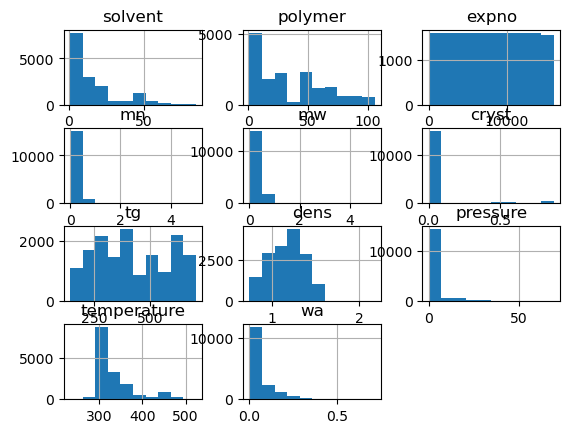

In [8]:
df_full.hist()

In [9]:
df_full.head()

solvent formula          name_x stype  polymer       abr  \
0        1     CO2  carbon dioxide    OX      1.0  Matrimid   
1        1     CO2  carbon dioxide    OX      1.0  Matrimid   
2        1     CO2  carbon dioxide    OX      1.0  Matrimid   
3        1     CO2  carbon dioxide    OX      1.0  Matrimid   
4        1     CO2  carbon dioxide    OX      1.0  Matrimid   

                                              name_y ptype  expno       mn  \
0  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   29.0  18000.0   
1  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   30.0  18000.0   
2  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   31.0  18000.0   
3  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   32.0  18000.0   
4  5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...    PI   33.0  18000.0   

        mw  cryst     tg   dens  pressure  temperature        wa  \
0  80000.0    0.0  611.0  1.225  0.096330       296.15  0.024814   
1  80000.0    0.0  611.0  1.225  0.444954       296.15  0.048406   
2  80000.0    0.0  611.0  1.225  0.779817       296.15  0.061171   
3  80000.0    0.0  611.0  1.225  1.133028       296.15  0.070268   
4  80000.0    0.0  611.0  1.225  1.477064       296.15  0.077454   

                             doi  \
0  10.1016/S0376-7388(02)00385-X   
1  10.1016/S0376-7388(02)00385-X   
2  10.1016/S0376-7388(02)00385-X   
3  10.1016/S0376-7388(02)00385-X   
4  10.1016/S0376-7388(02)00385-X   

                                               notes  sol-pol  
0  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
1  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
2  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
3  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1  
4  Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...  1.0 - 1

In [10]:
# Rename
df_full.rename(columns = {'formula': 'sol',
                       'abr': 'pol'}, inplace = True)

df_full['sol'] = df_full['sol'].astype('category')
df_full['pol'] = df_full['pol'].astype('category')

In [11]:
print("Unique solvents:", df_full['sol'].unique())

print()
print("Unique polymers:", df_full['pol'].unique())


Unique solvents: ['CO2', 'CH4', 'C4H10', 'CClF2CH3', 'CF3CH2F', ..., 'C4H8O2', 'C2H5COC2H5', 'C3H7OC3H7', 'CH3NO2', '(C2H3)OCOCH3']
Length: 73
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

Unique polymers: ['Matrimid', 'PCL', 'PE', 'PEG', 'PET', ..., 'PEV', 'P4VP', 'PVME', '6FDA-5CMPD', '6FDA-44DDM']
Length: 106
Categories (105, object): ['6FDA-34DPE', '6FDA-44DDM', '6FDA-4`4-DPE', '6FDA-5CMPD', ..., 'TMPSF', 'mPBI', 'poly(2-EAdMA)', 'poly(2-MAdMA)']


Limit prediction to CO2 only:

In [12]:
df_co2=df_full.loc[df_full["sol"] == "CO2"]

In [13]:
df_co2['sol'].unique()

['CO2']
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

# Data exploration

## Visualise our Feature / Target Relationship

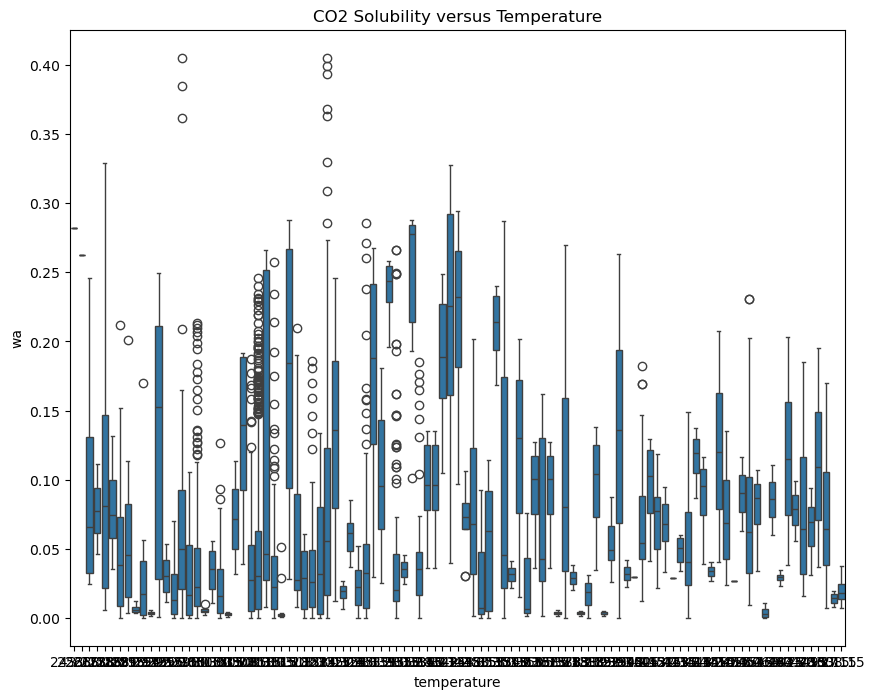

In [14]:
# Temperature
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='temperature', y='wa')
ax.set_title('CO2 Solubility versus Temperature')
plt.show()

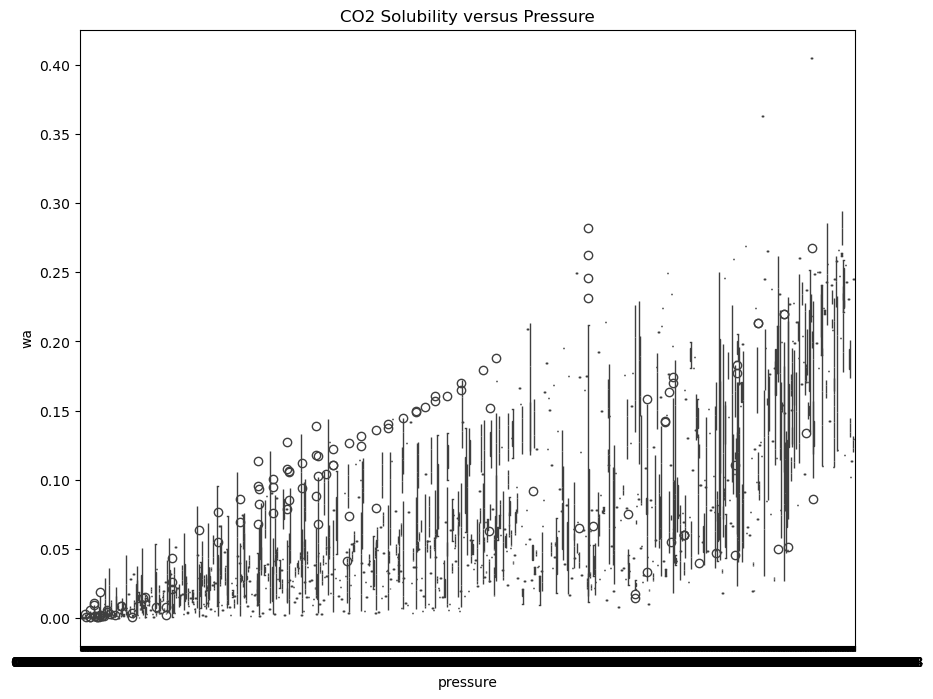

In [15]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='pressure', y='wa')
ax.set_title('CO2 Solubility versus Pressure')
plt.show()

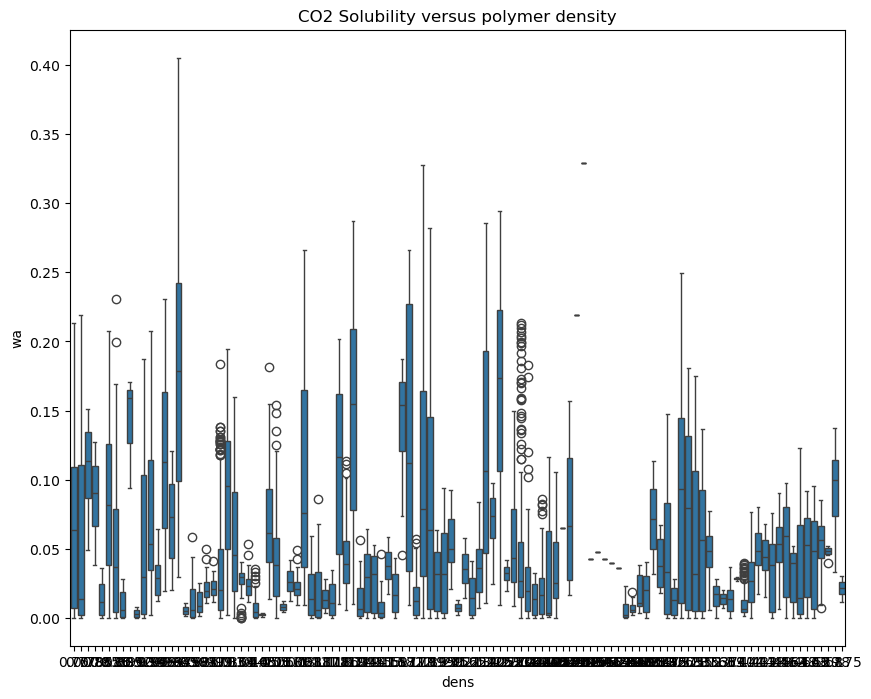

In [16]:
# Density
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='dens', y='wa')
ax.set_title('CO2 Solubility versus polymer density')
plt.show()

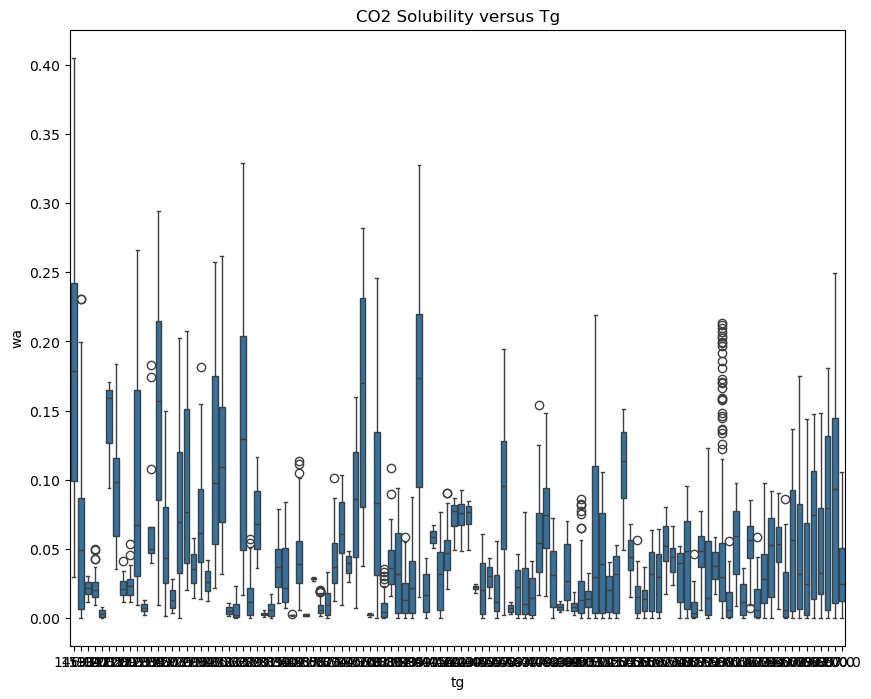

In [17]:
# Tg
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='tg', y='wa')
ax.set_title('CO2 Solubility versus Tg')
plt.show()

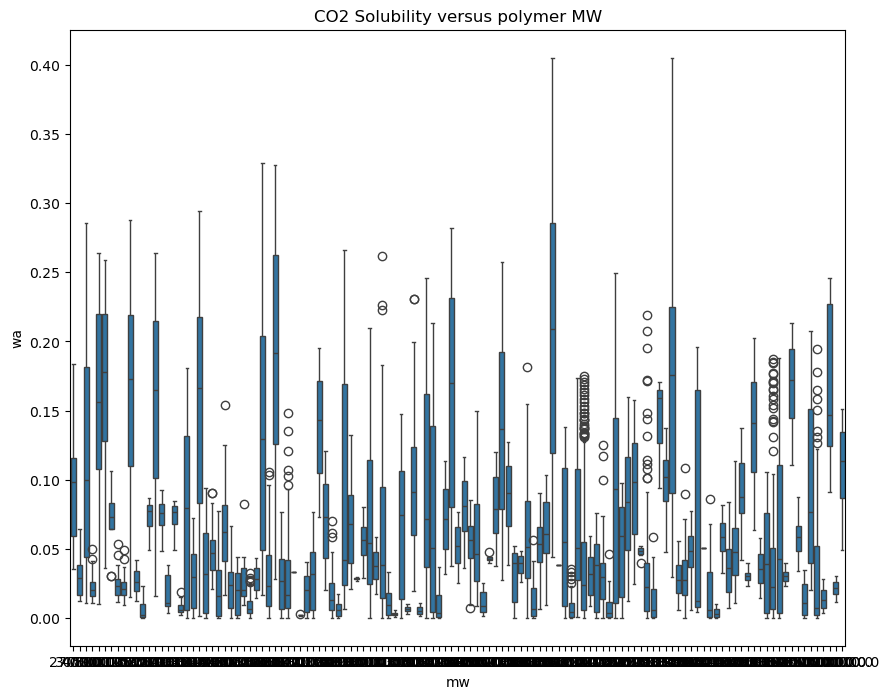

In [18]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mw', y='wa')
ax.set_title('CO2 Solubility versus polymer MW')
plt.show()

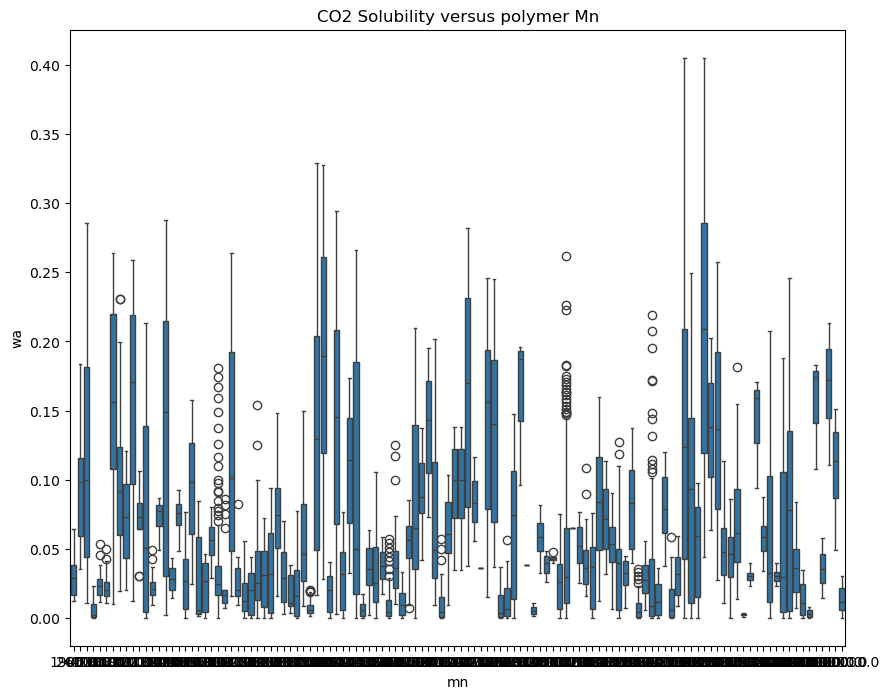

In [19]:
# mn
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mn', y='wa')
ax.set_title('CO2 Solubility versus polymer Mn')
plt.show()

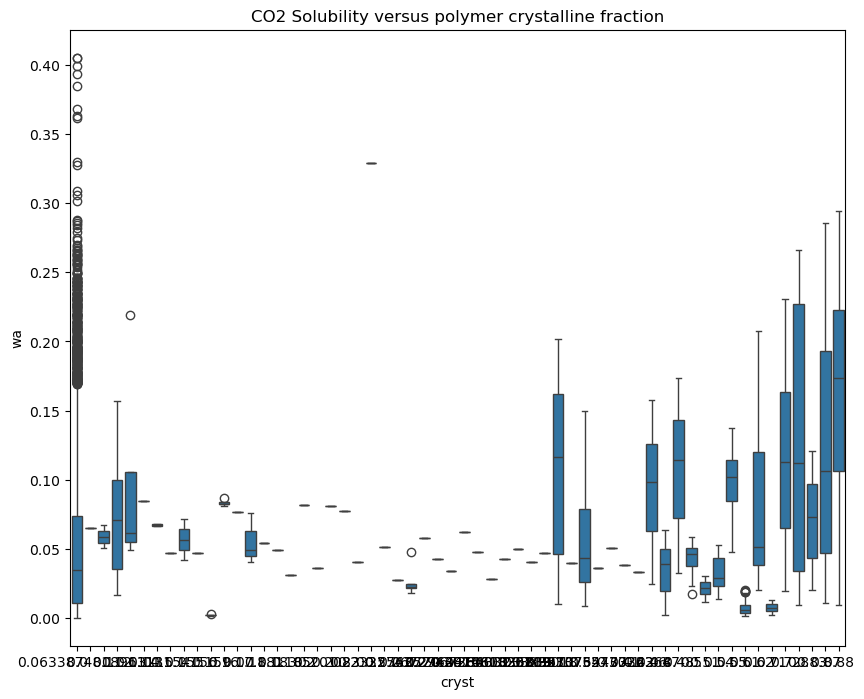

In [20]:
# Crystalline fraction
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='cryst', y='wa')
ax.set_title('CO2 Solubility versus polymer crystalline fraction')
plt.show()

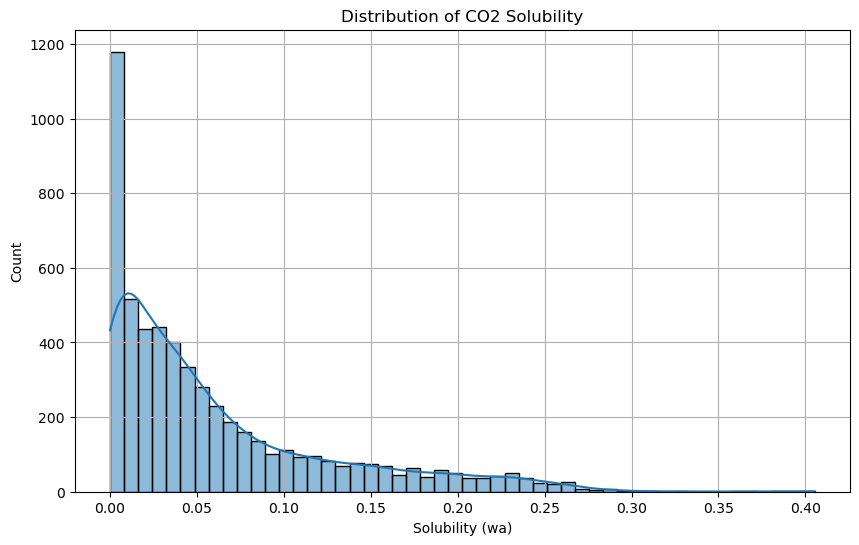

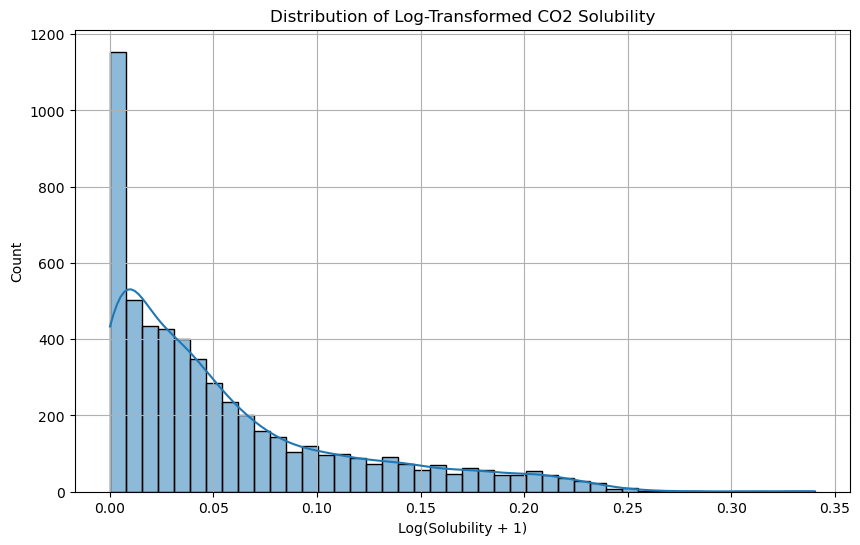

In [21]:
# Distribution of the target variable (solubility)
plt.figure(figsize=(10, 6))
sns.histplot(df_co2['wa'], kde=True)
plt.title('Distribution of CO2 Solubility')
plt.xlabel('Solubility (wa)')
plt.grid(True)
plt.show()

# Log transform if skewed
if df_co2['wa'].skew() > 0.5:
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(df_co2['wa']), kde=True)
    plt.title('Distribution of Log-Transformed CO2 Solubility')
    plt.xlabel('Log(Solubility + 1)')
    plt.grid(True)
    plt.show()

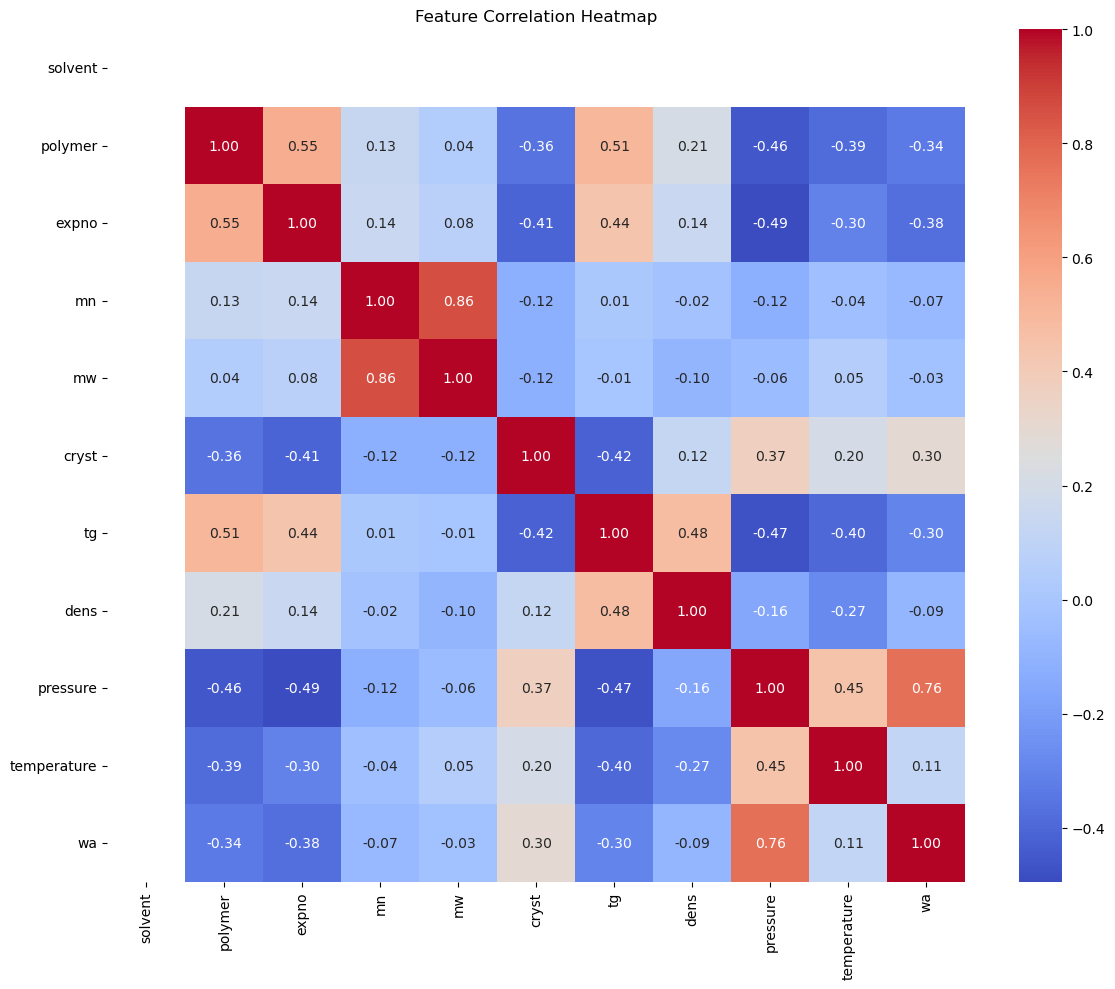

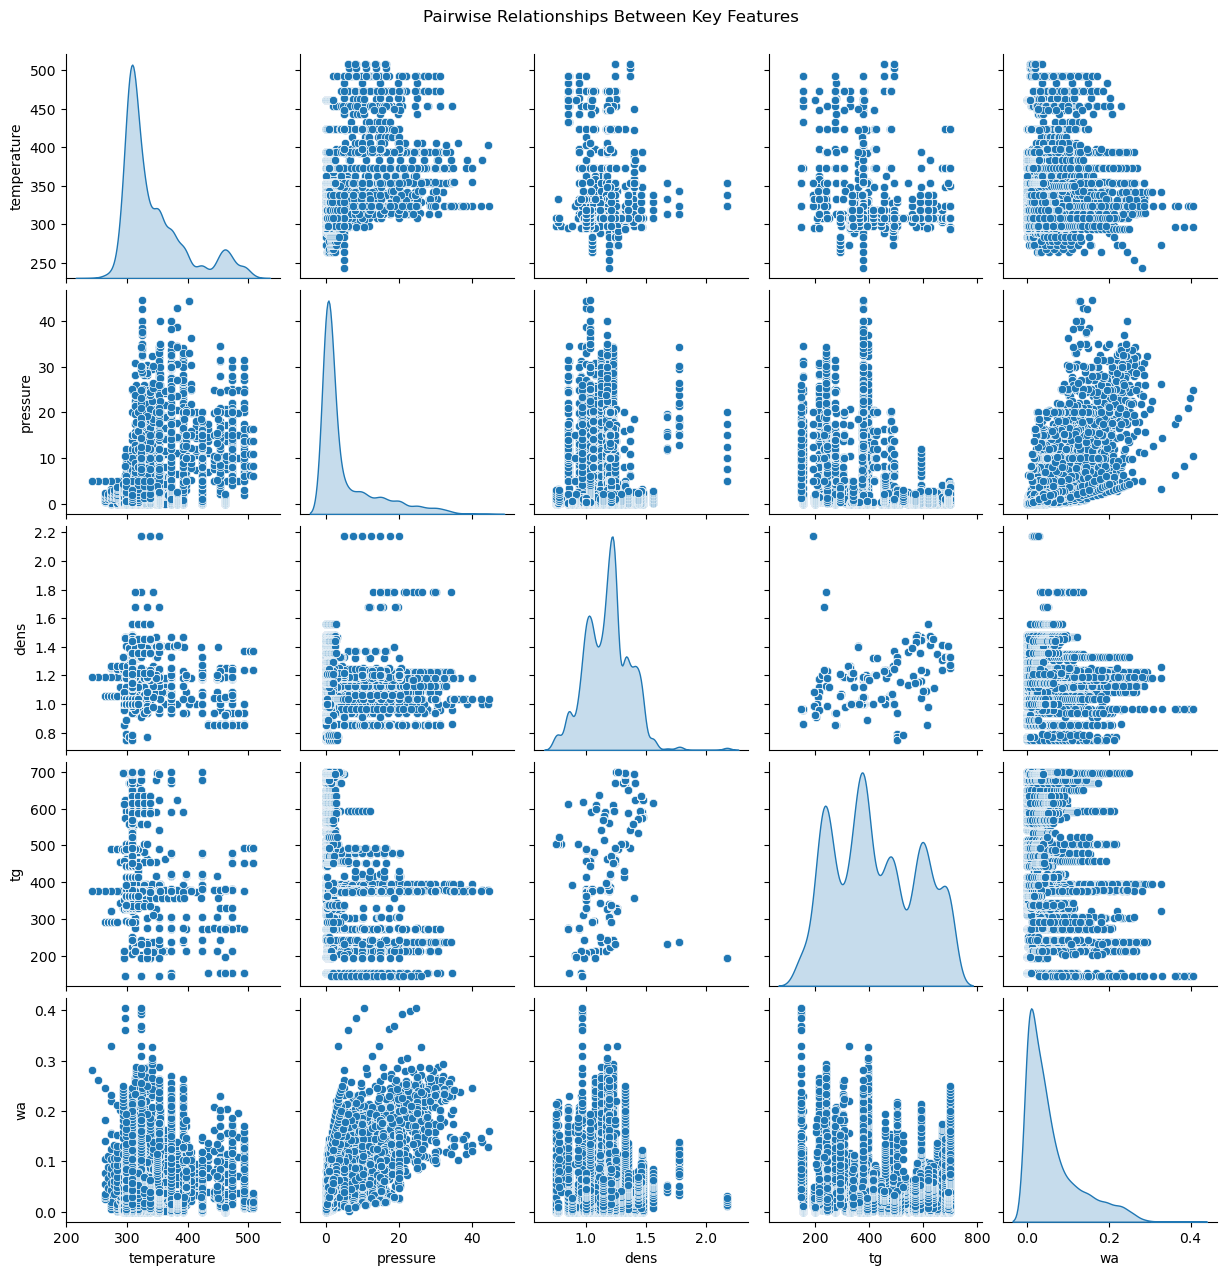

In [22]:
# Correlation heatmap of numeric features
numeric_cols = df_co2.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
correlation = df_co2[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Pairplot for key features
key_features = ['temperature', 'pressure', 'dens', 'tg', 'wa']
sns.pairplot(df_co2[key_features], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Key Features', y=1.02)
plt.show()

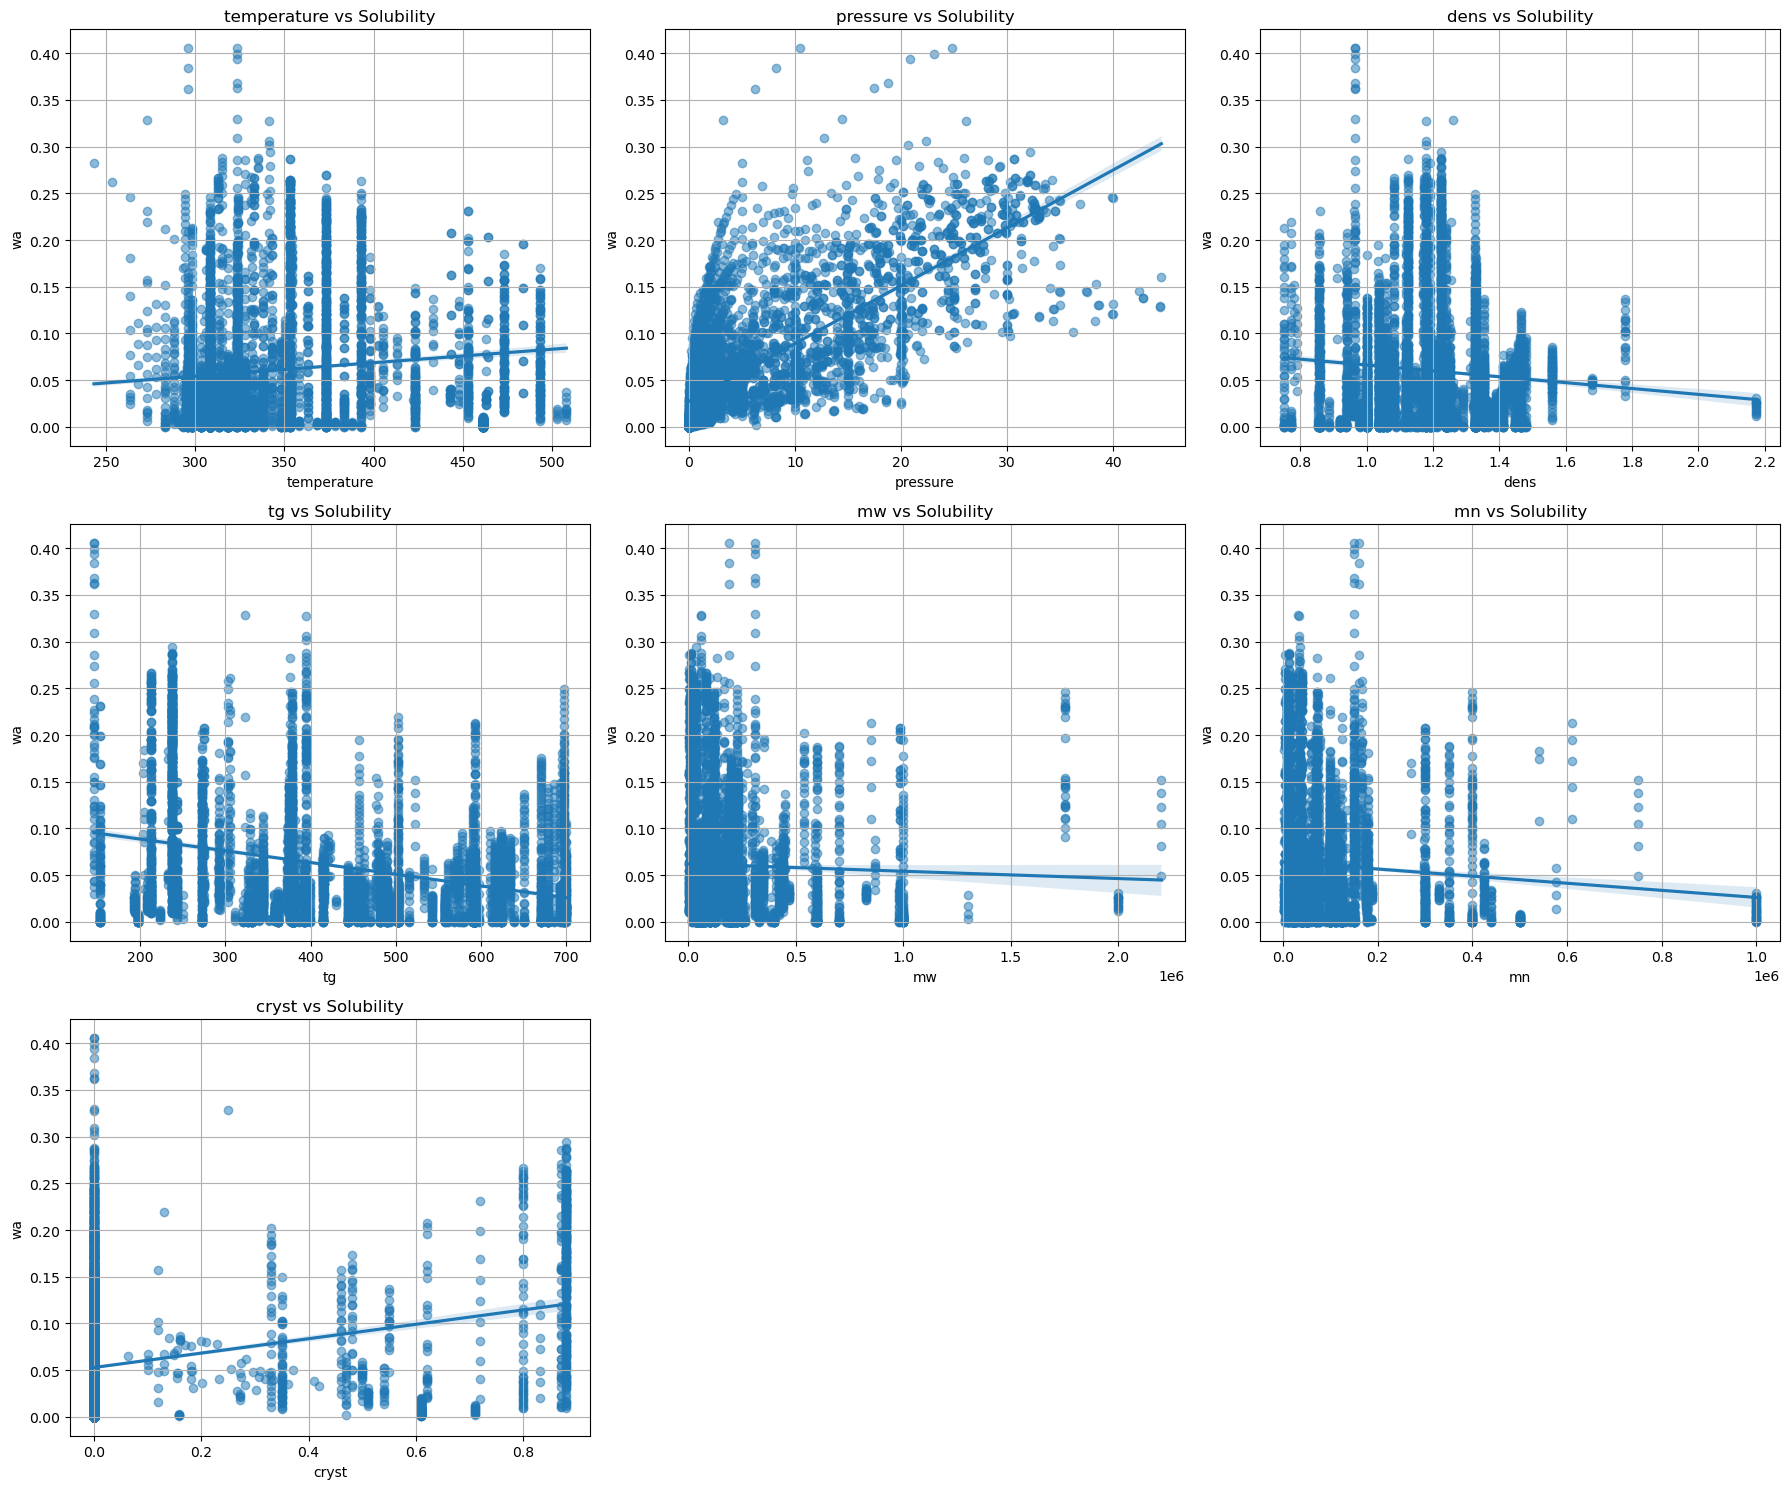

In [23]:
# Scatterplots with regression line for continuous features
features_to_plot = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    if i < len(axes):
        sns.regplot(x=feature, y='wa', data=df_co2, ax=axes[i], scatter_kws={'alpha':0.5})
        axes[i].set_title(f'{feature} vs Solubility')
        axes[i].grid(True)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

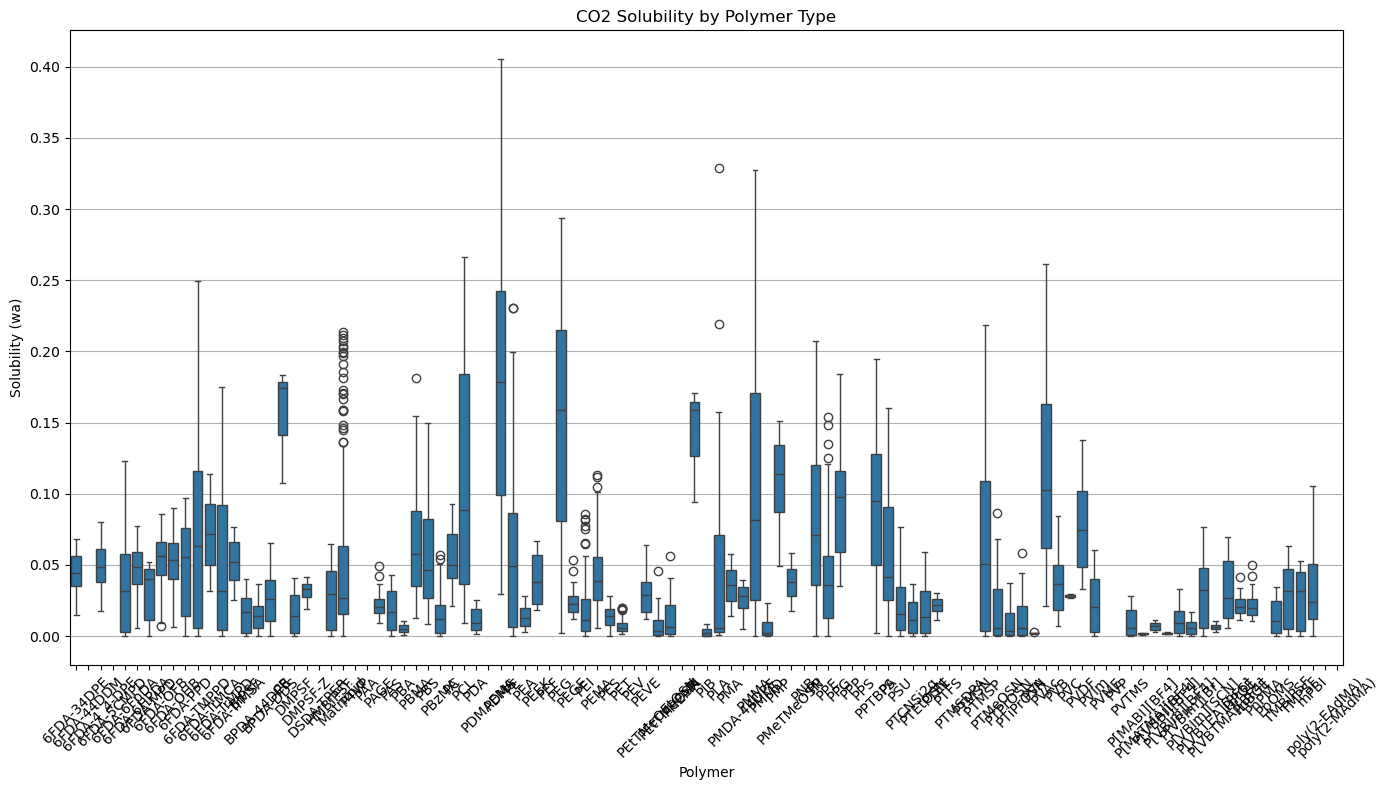

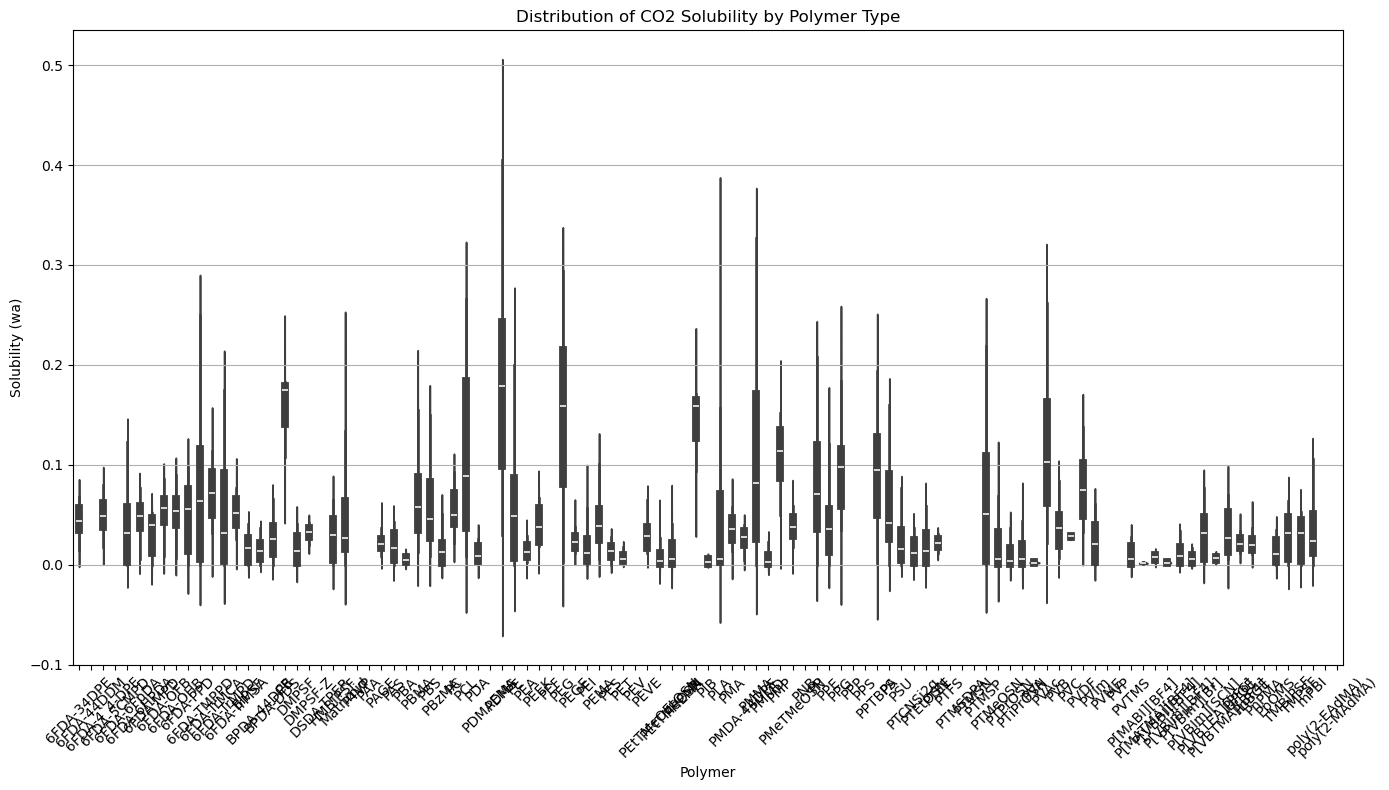

In [24]:
# Boxplot of solubility by polymer type
plt.figure(figsize=(14, 8))
sns.boxplot(x='pol', y='wa', data=df_co2)
plt.xticks(rotation=45)
plt.title('CO2 Solubility by Polymer Type')
plt.xlabel('Polymer')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Violin plots to see distribution shapes
plt.figure(figsize=(14, 8))
sns.violinplot(x='pol', y='wa', data=df_co2)
plt.xticks(rotation=45)
plt.title('Distribution of CO2 Solubility by Polymer Type')
plt.xlabel('Polymer')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Step 1: `features = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]`

In [25]:
features = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]   # features to use
TARGET_COL = 'wa'  # target (solubility)
df_co2_f = df_co2[features + [TARGET_COL]]

num_cols = [c for c in df_co2_f.columns if df_co2[c].dtype != 'object' and c not in ['sol','pol', TARGET_COL]]
cat_cols = [c for c in df_co2_f.columns if df_co2[c].dtype == 'object']

preprocessor = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])


In [26]:
cat_cols

[]

In [27]:
print("NaN counts in df_co2_f before splitting:")
print(df_co2_f.isnull().sum())

df_co2_f = df_co2_f.dropna()

NaN counts in df_co2_f before splitting:
temperature    0
pressure       0
dens           0
tg             0
mw             0
mn             0
cryst          0
wa             0
dtype: int64


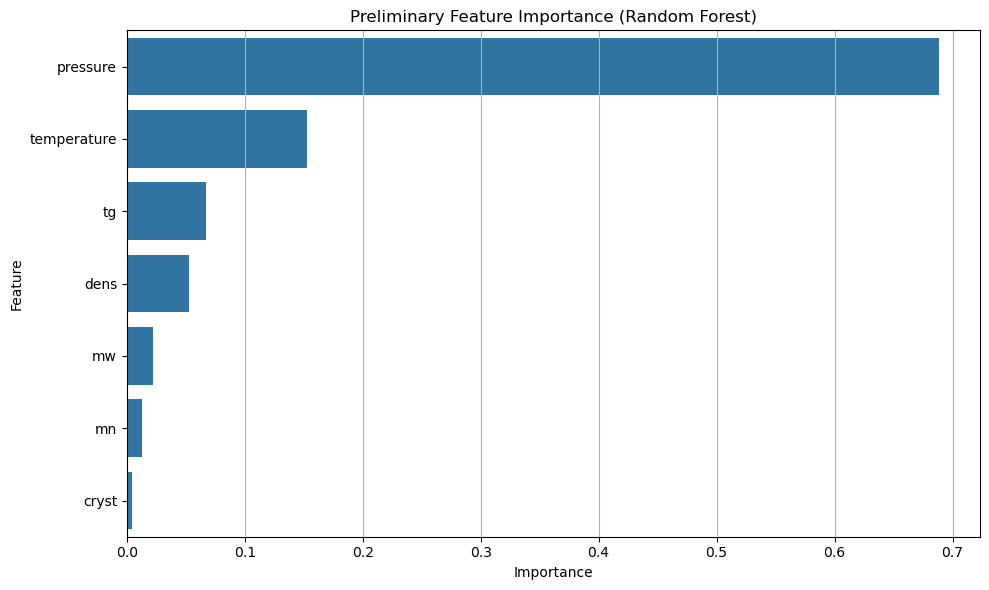

In [28]:
# Simple feature importance visualization using Random Forest
from sklearn.ensemble import RandomForestRegressor

X = df_co2_f.drop(columns=[TARGET_COL])
y = df_co2_f[TARGET_COL]

# Fit a simple Random Forest
rf_prelim = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
rf_prelim.fit(X, y)

# Plot feature importance
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_prelim.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Preliminary Feature Importance (Random Forest)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

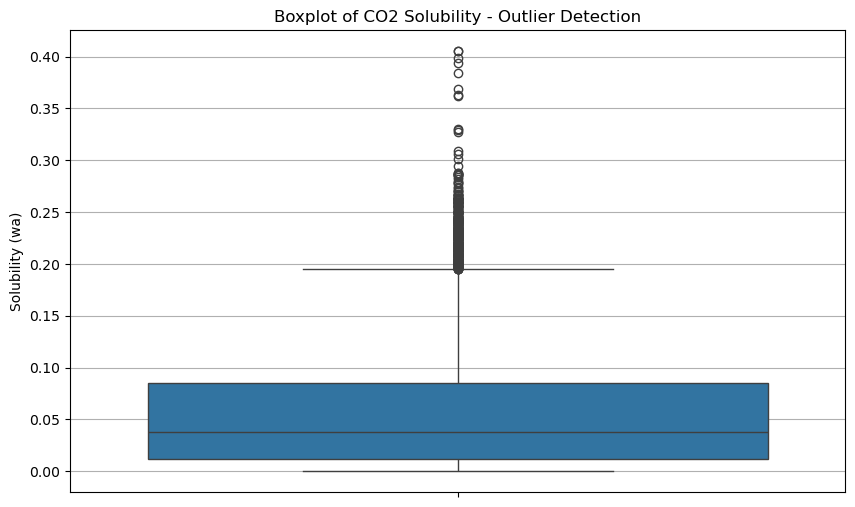

Outliers in temperature: 526 points
  Range: 448.15 to 508.15
Outliers in pressure: 577 points
  Range: 17.9 to 44.5541235255298
Outliers in dens: 33 points
  Range: 1.78 to 2.175
Outliers in tg: 0 points
Outliers in mw: 468 points
  Range: 451000.0 to 2200000.0
Outliers in mn: 473 points
  Range: 271000.0 to 1000000.0
Outliers in cryst: 846 points
  Range: 0.063387481896113 to 0.88


In [29]:
# Boxplot for outlier detection in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_co2['wa'])
plt.title('Boxplot of CO2 Solubility - Outlier Detection')
plt.ylabel('Solubility (wa)')
plt.grid(True, axis='y')
plt.show()

# IQR method for detecting outliers in features
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Check outliers in key features
for feature in features_to_plot:
    outliers = detect_outliers(df_co2, feature)
    print(f"Outliers in {feature}: {len(outliers)} points")
    if len(outliers) > 0:
        print(f"  Range: {outliers.min()} to {outliers.max()}")

### EDA

C:\Users\sieun\AppData\Local\Temp\ipykernel_11288\929254817.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


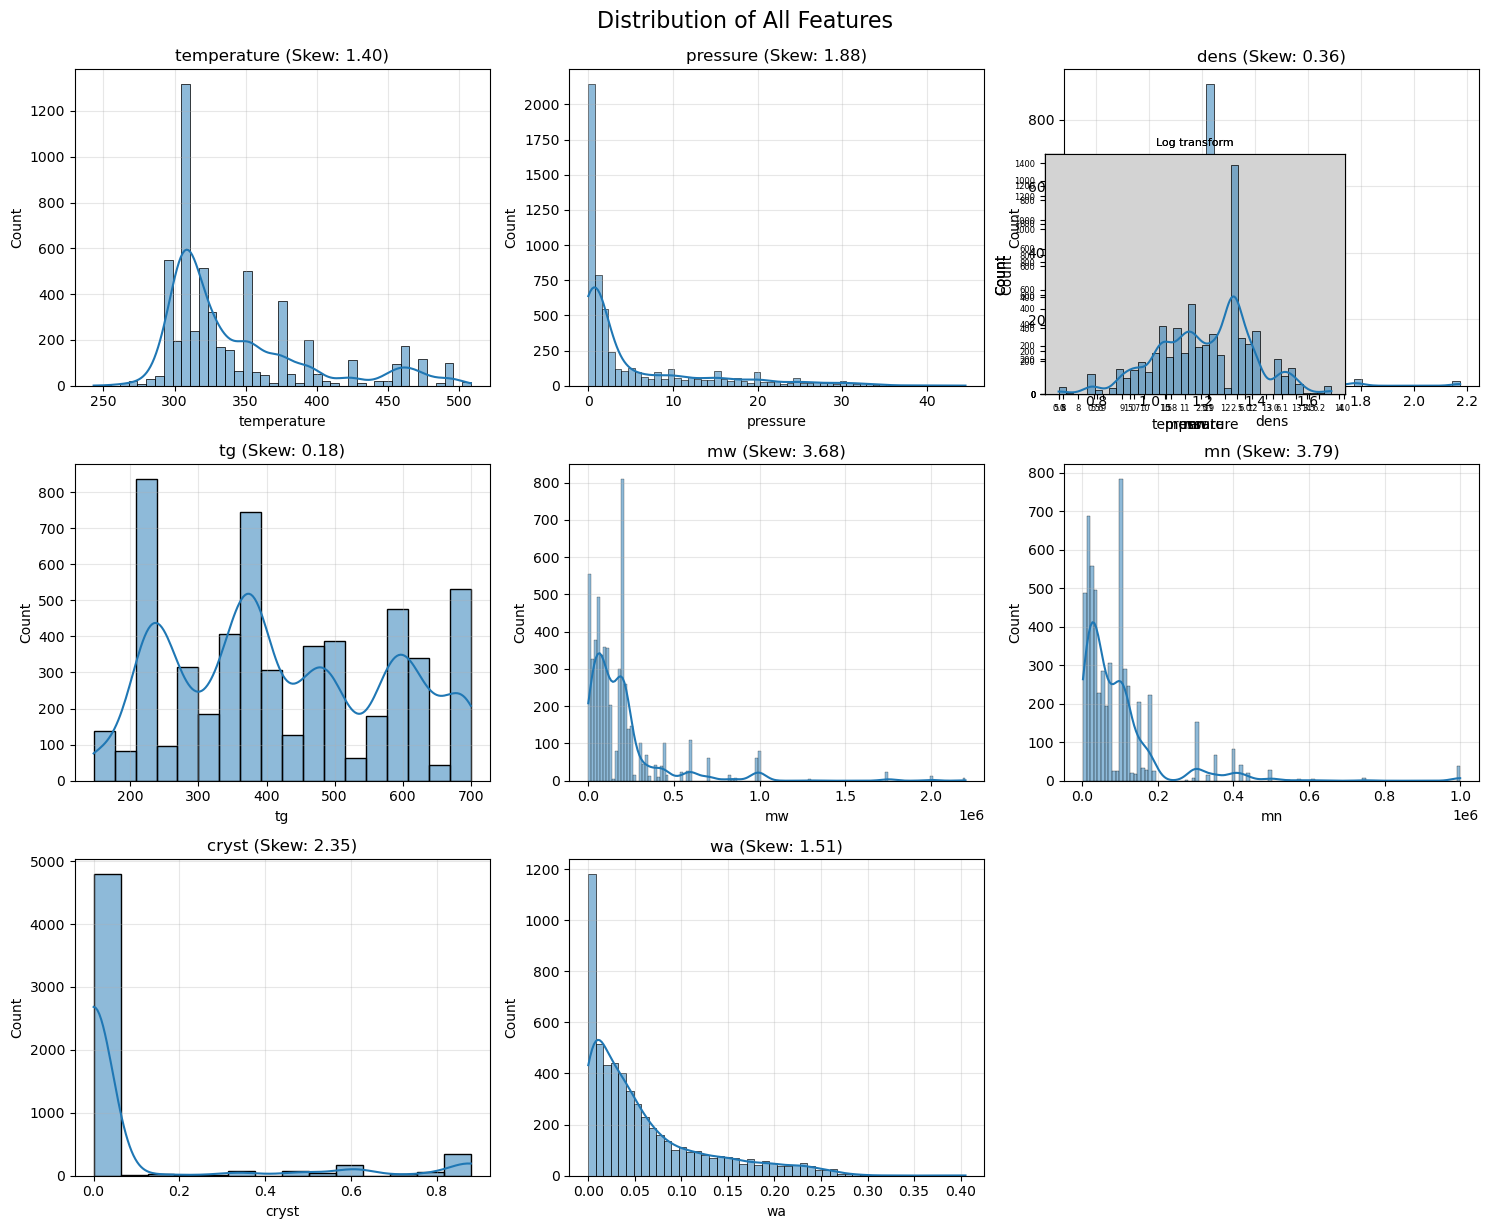

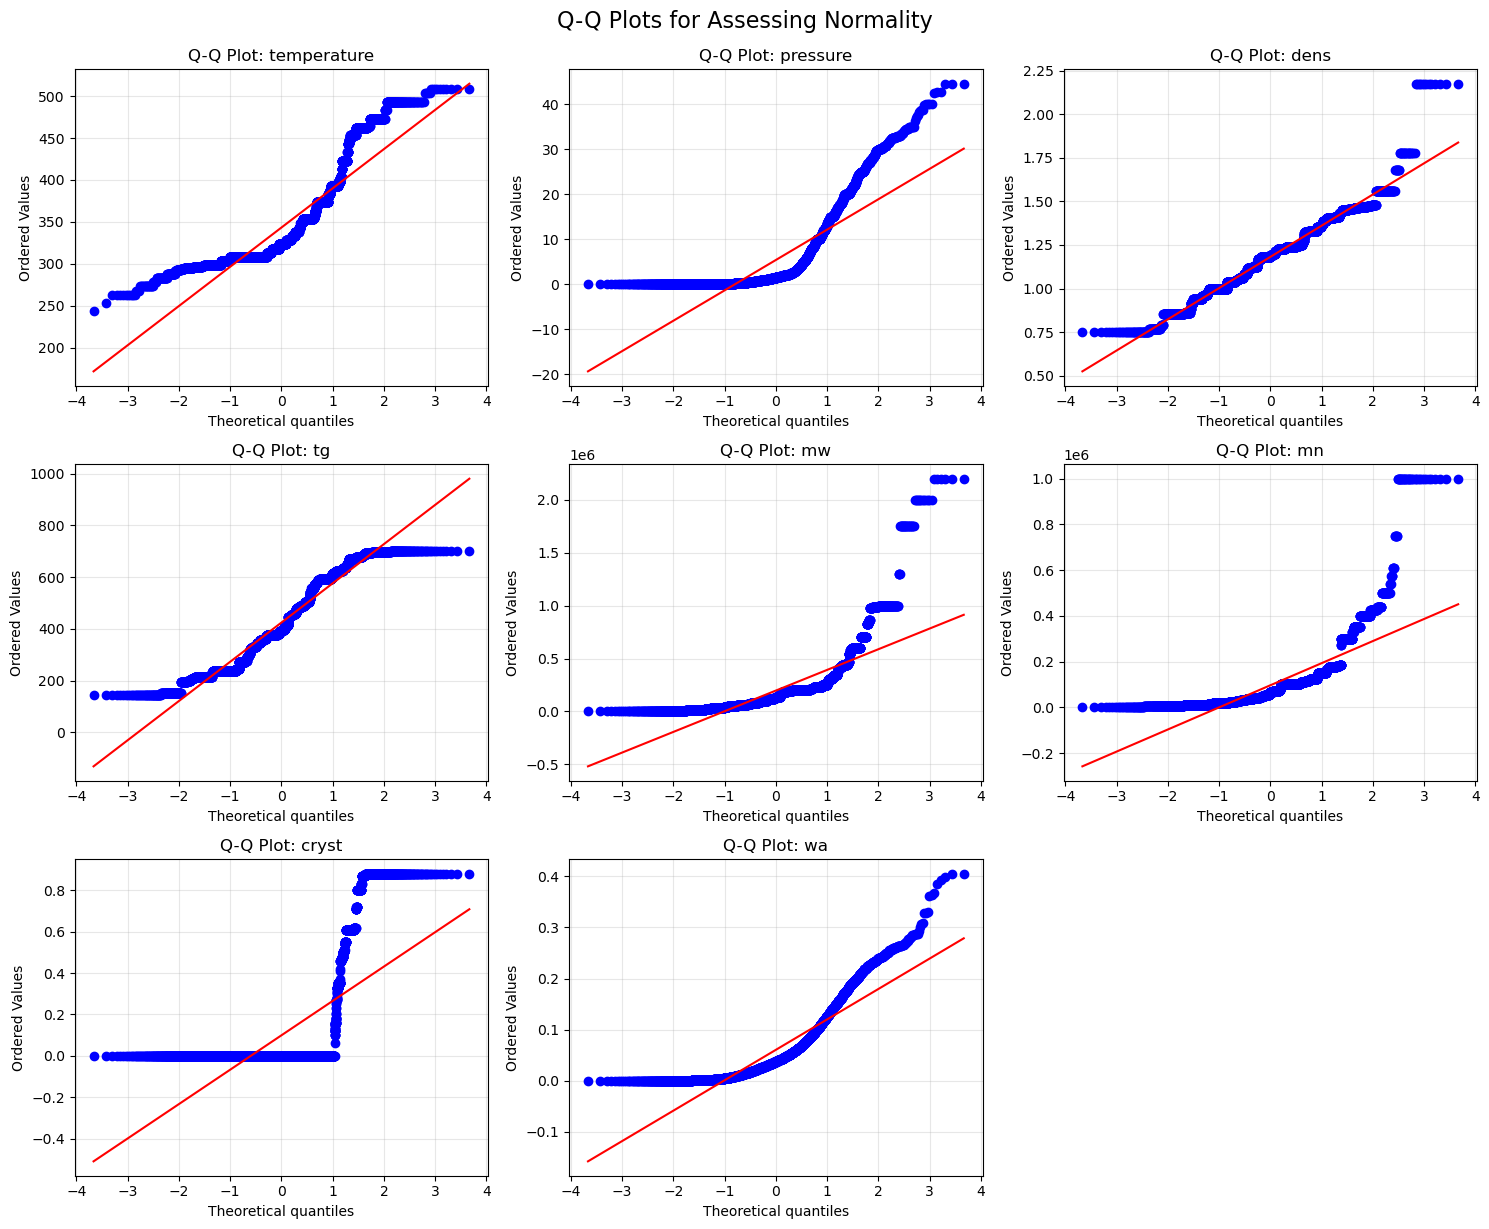

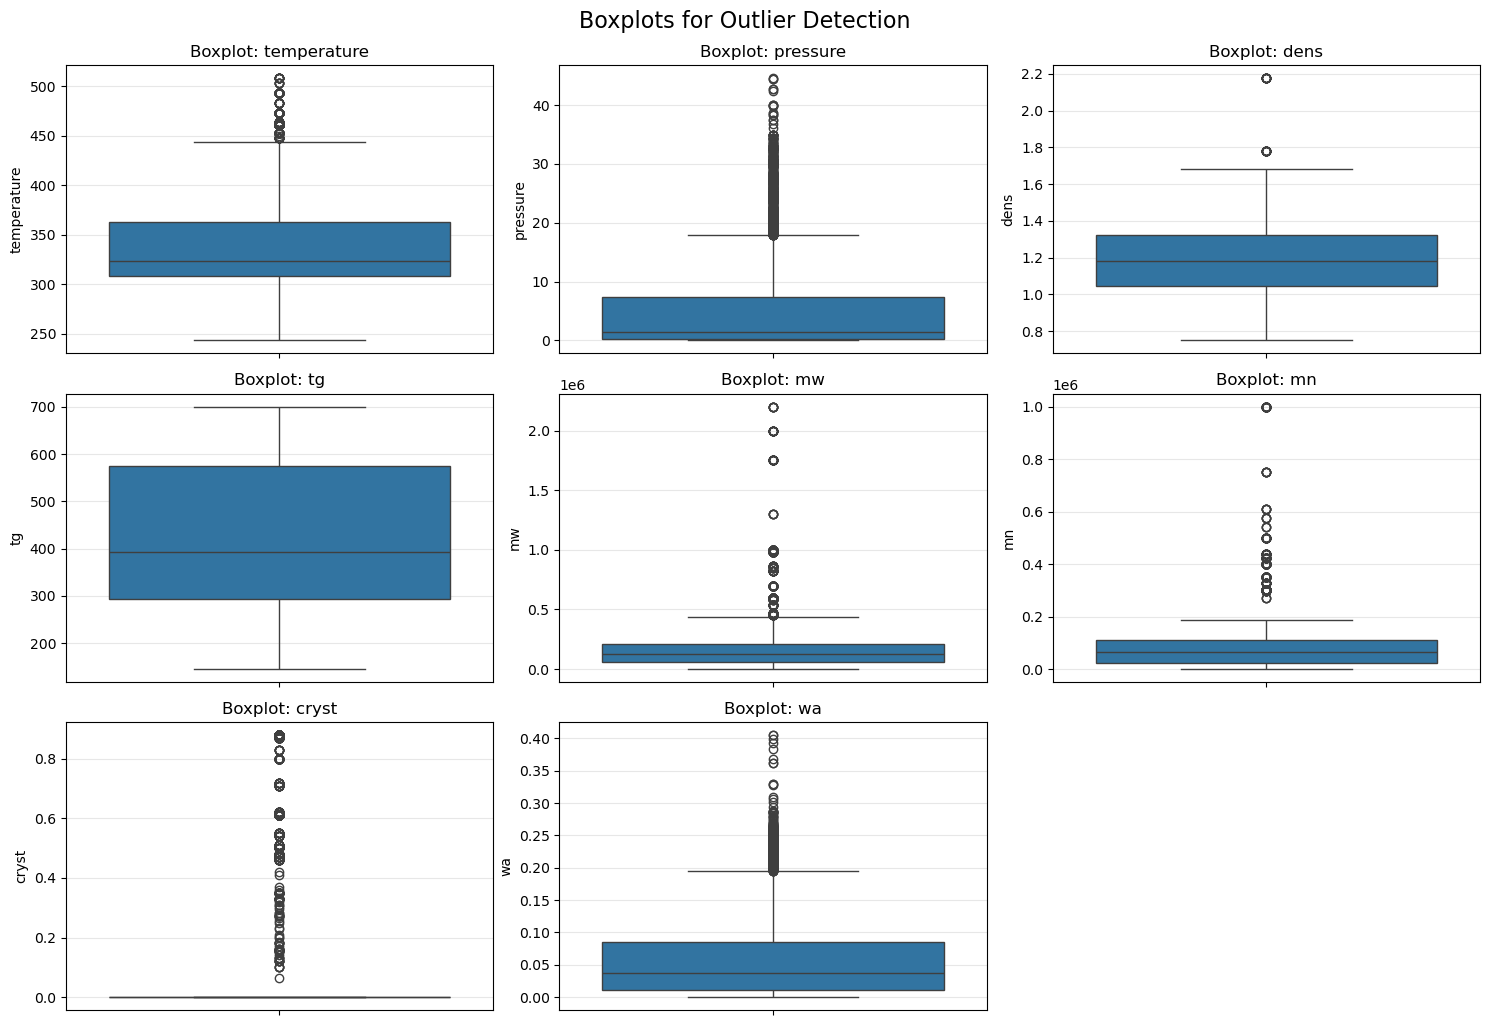

Summary statistics for numerical features:
              count           mean            std        min           25%  \
temperature  5635.0     343.294412      51.658444   243.1500    308.150000   
pressure     5635.0       5.356234       8.090711     0.0001      0.249863   
dens         5635.0       1.181440       0.181321     0.7500      1.046000   
tg           5635.0     424.376868     155.361713   146.0000    293.000000   
mw           5635.0  197140.097604  246533.561363  2700.0000  60000.000000   
mn           5635.0   96441.559795  121822.141337  1900.0000  25000.000000   
cryst        5635.0       0.099346       0.251824     0.0000      0.000000   
wa           5635.0       0.060513       0.065636     0.0001      0.011641   

                       50%            75%           max      skew       kurt  
temperature     323.150000     363.150000  5.081500e+02  1.400271   1.115014  
pressure          1.438819       7.298601  4.455412e+01  1.879111   2.907926  
dens             

In [31]:
# Distribution analysis of all numerical features
from scipy import stats


plt.figure(figsize=(15, 12))
features_plus_target = features + [TARGET_COL]  # Include target variable
n_features = len(features_plus_target)
rows = (n_features + 1) // 3  # Calculate needed rows for 3 columns

for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    
    # Plot histogram with KDE
    sns.histplot(df_co2_f[feature], kde=True)
    
    # Add skewness value to the plot
    skew = df_co2_f[feature].skew()
    plt.title(f'{feature} (Skew: {skew:.2f})')
    plt.grid(True, alpha=0.3)
    
    # Check if log transformation might help for highly skewed features
    if abs(skew) > 1 and feature != TARGET_COL and df_co2_f[feature].min() > 0:
        # Small subplot for log-transformed version
        ax2 = plt.axes([0.70, 0.70, 0.20, 0.20], facecolor='lightgrey')
        sns.histplot(np.log1p(df_co2_f[feature]), kde=True, ax=ax2)
        ax2.set_title('Log transform', fontsize=8)
        ax2.tick_params(labelsize=6)
        ax2.grid(False)

plt.tight_layout()
plt.suptitle('Distribution of All Features', fontsize=16, y=1.02)
plt.show()

# QQ plots to assess normality
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    stats.probplot(df_co2_f[feature], plot=plt)
    plt.title(f'Q-Q Plot: {feature}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Q-Q Plots for Assessing Normality', fontsize=16, y=1.02)
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_plus_target):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(df_co2_f[feature])
    plt.title(f'Boxplot: {feature}')
    plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection', fontsize=16, y=1.02)
plt.show()

# Summary statistics for features
print("Summary statistics for numerical features:")
stats_df = df_co2_f[features_plus_target].describe().T
stats_df['skew'] = df_co2_f[features_plus_target].skew()
stats_df['kurt'] = df_co2_f[features_plus_target].kurt()
print(stats_df)

# Check for features that might benefit from transformation
print("\nFeatures that might benefit from transformation (|skew| > 1):")
for feature in features:
    skew = df_co2_f[feature].skew()
    if abs(skew) > 1:
        print(f"{feature}: skew = {skew:.2f}")

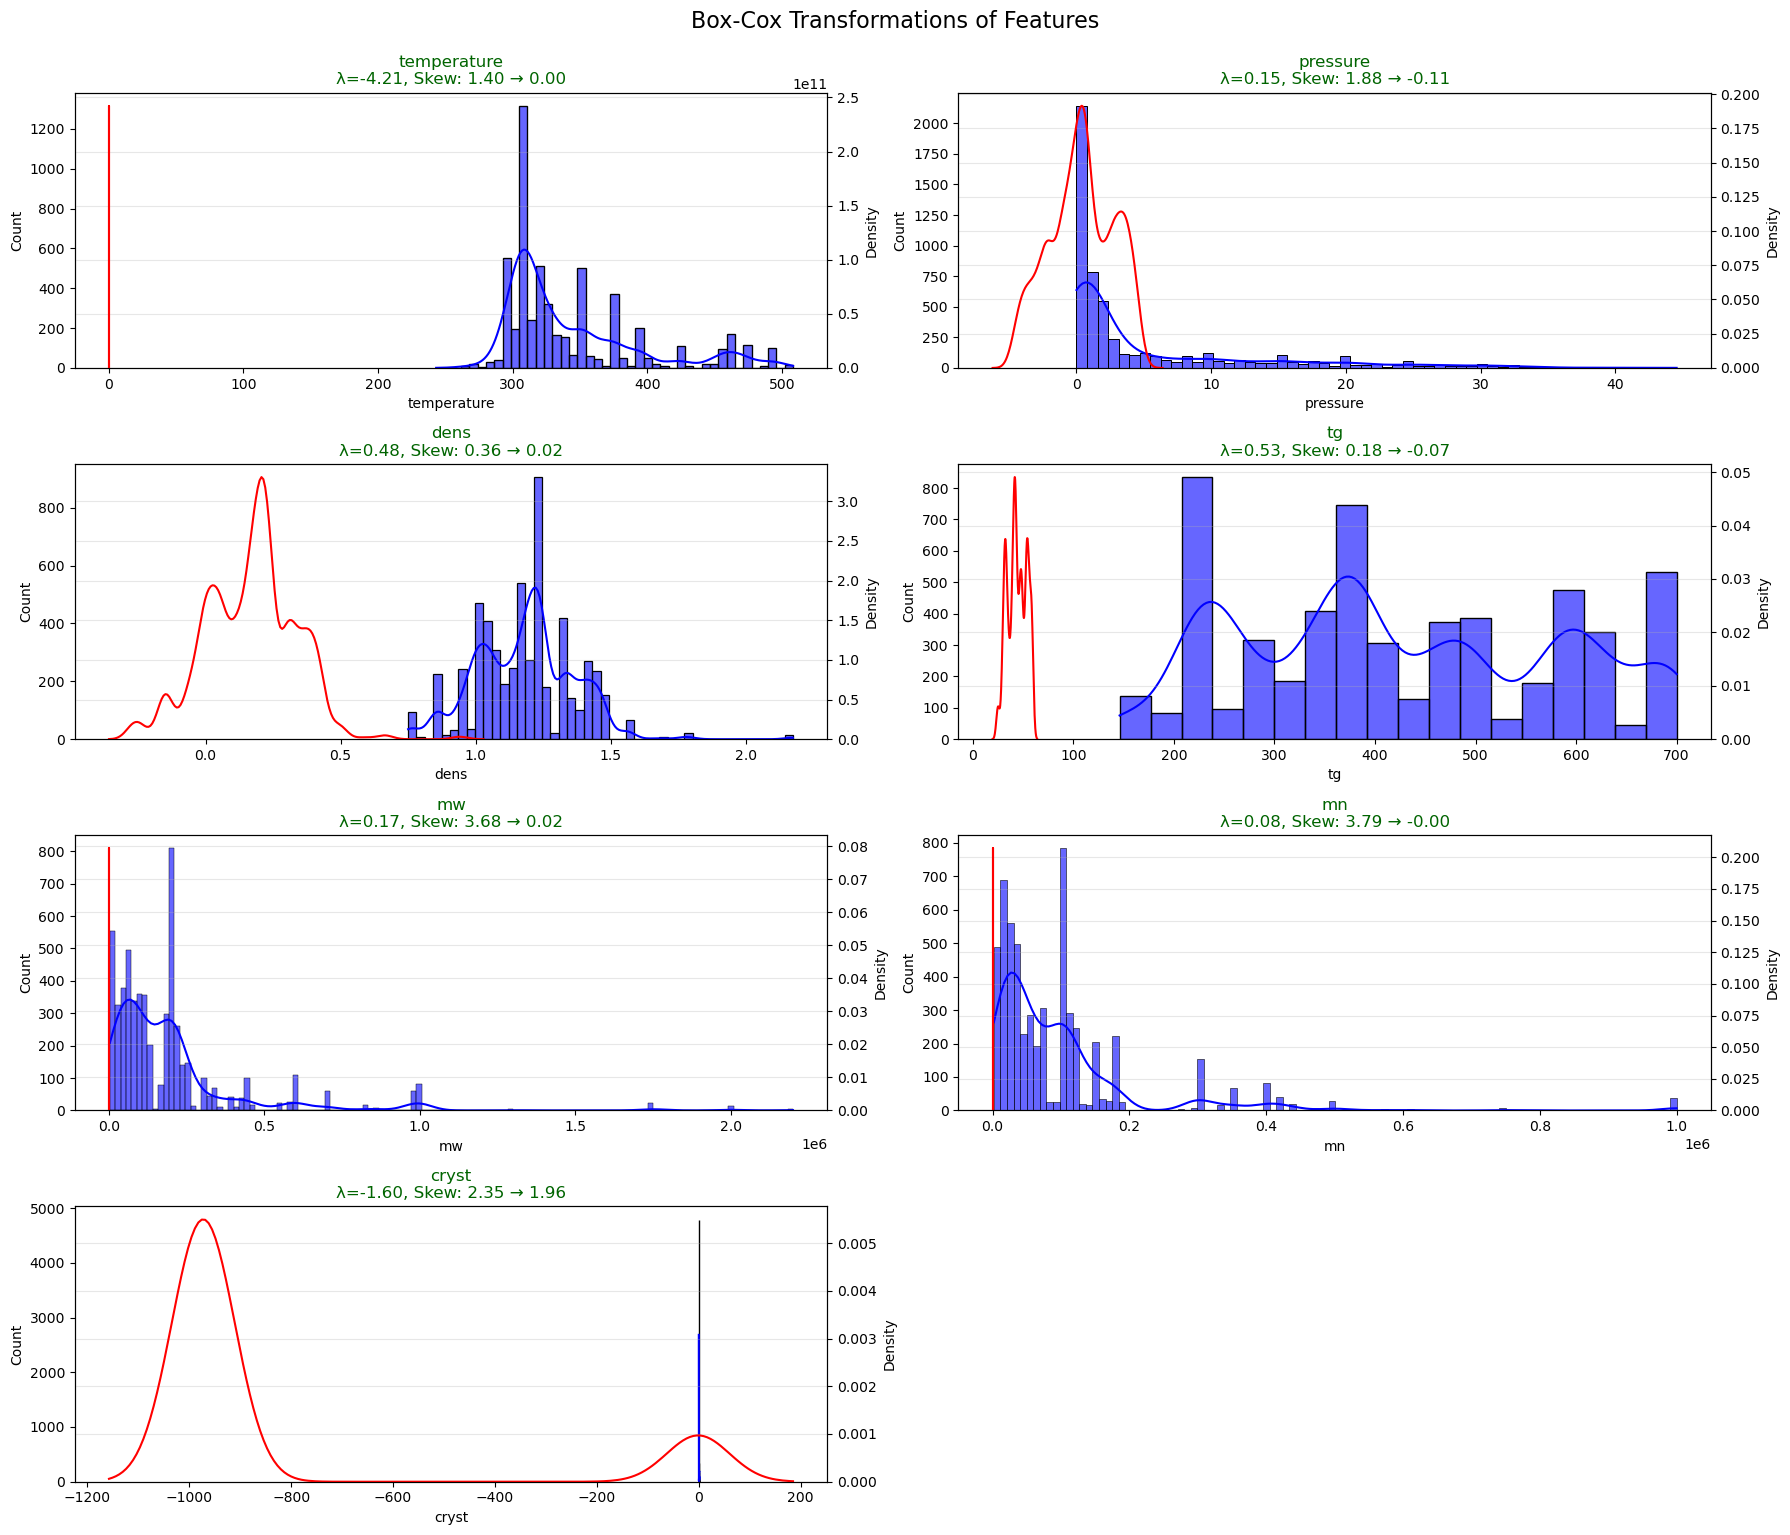

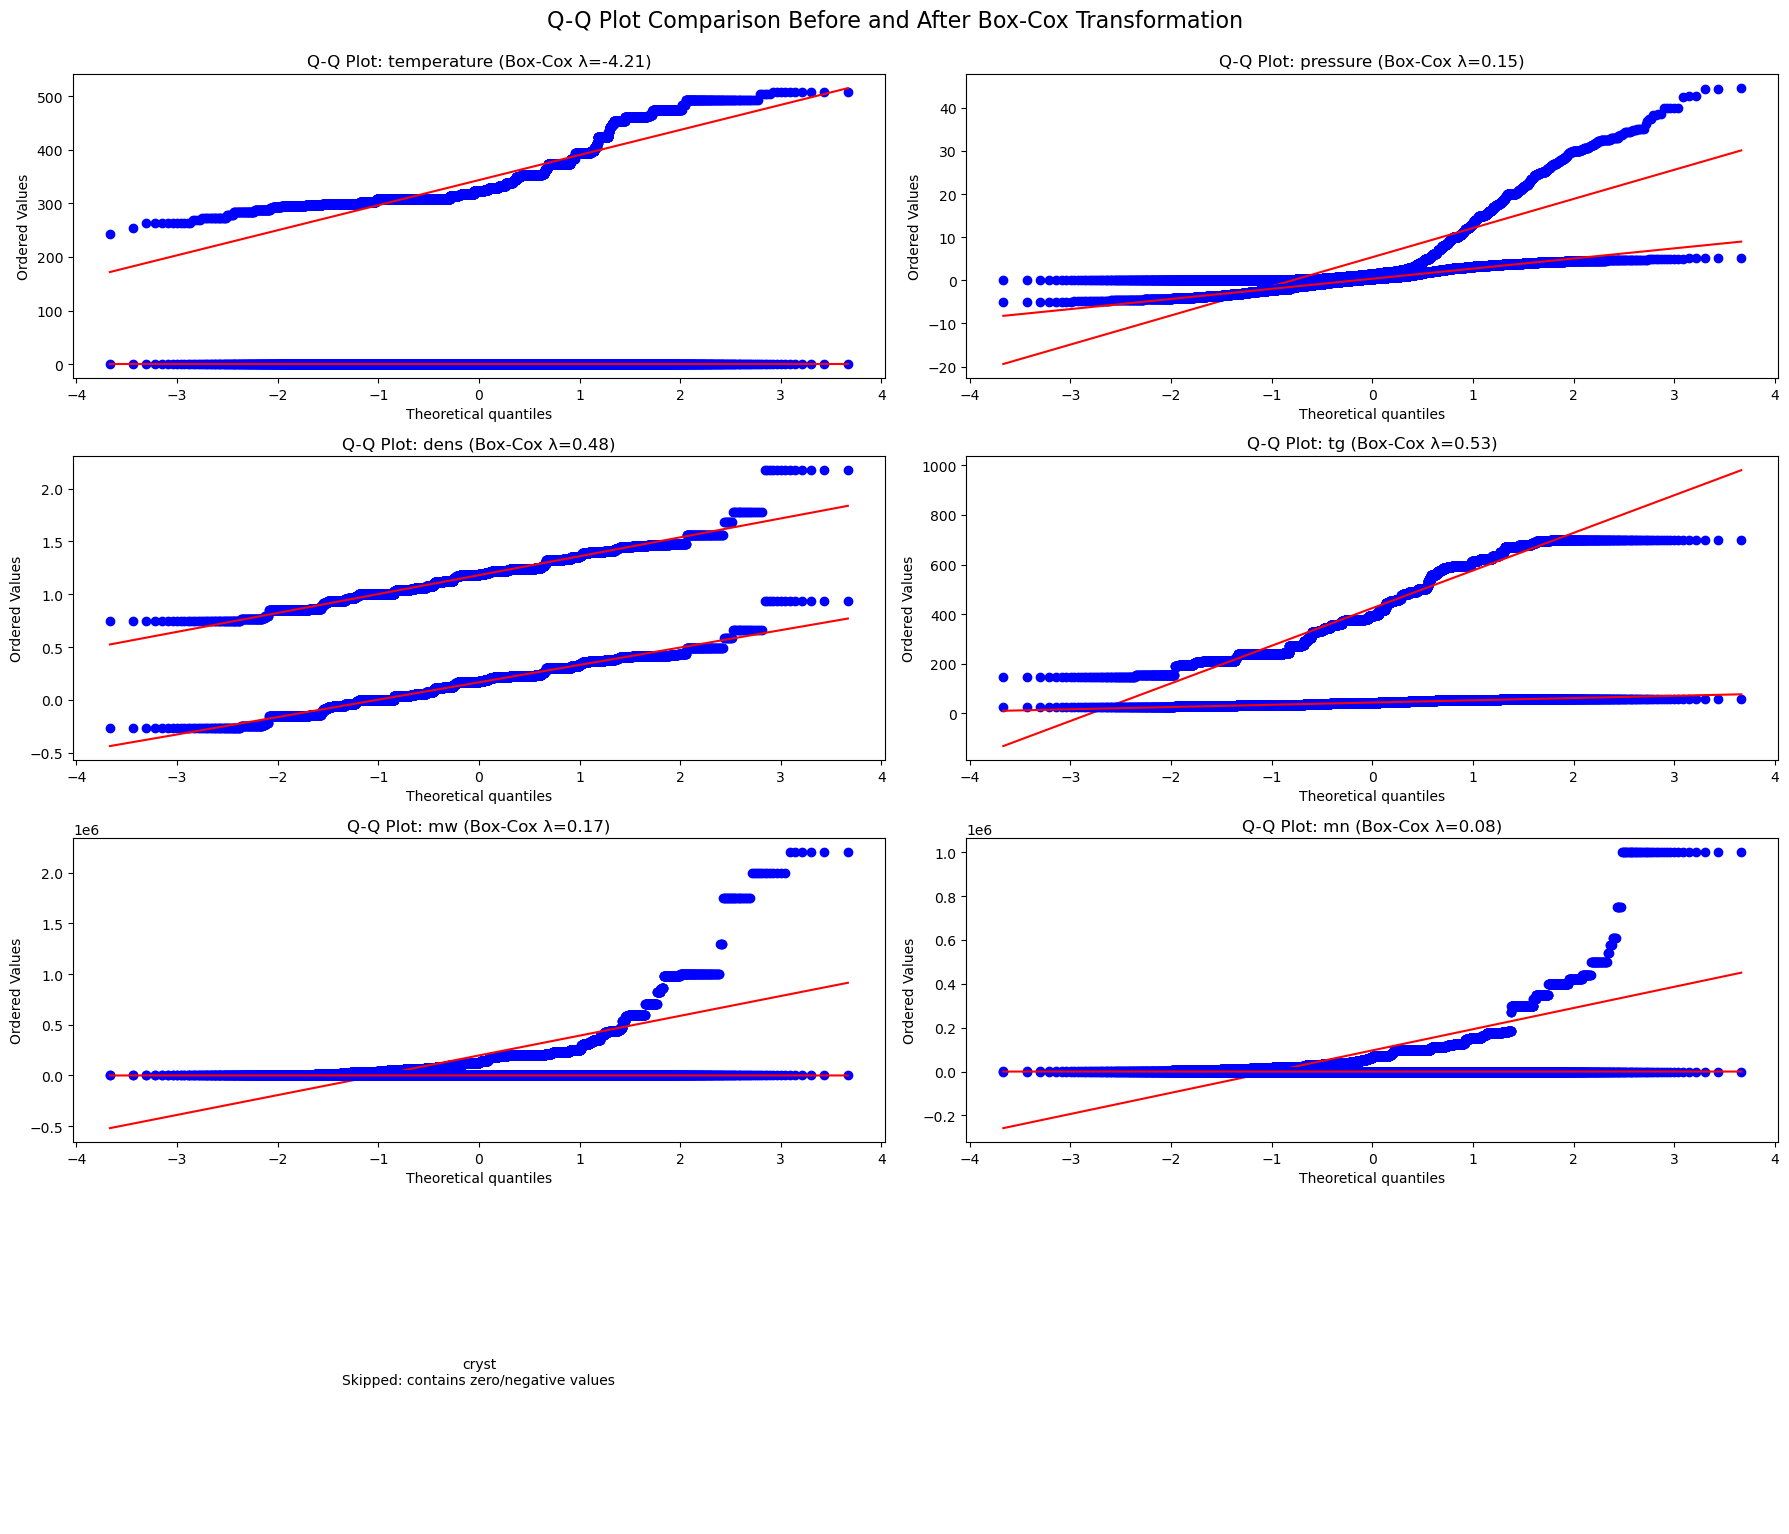


Summary of Box-Cox Transformations:
temperature: λ=-4.2117, Skew: 1.40 → 0.00 (IMPROVED)
pressure: λ=0.1517, Skew: 1.88 → -0.11 (IMPROVED)
dens: λ=0.4778, Skew: 0.36 → 0.02 (IMPROVED)
tg: λ=0.5303, Skew: 0.18 → -0.07 (IMPROVED)
mw: λ=0.1670, Skew: 3.68 → 0.02 (IMPROVED)
mn: λ=0.0772, Skew: 3.79 → -0.00 (IMPROVED)
cryst: Cannot transform (contains zero/negative values). Original skew = 2.35

Recommended features for Box-Cox transformation: ['temperature', 'pressure', 'mw', 'mn']

Target variable 'wa':
  Original skew: 1.51
  Box-Cox λ: 0.2736
  Transformed skew: -0.13
  Recommendation: Consider transforming target


In [32]:
# Automatic Box-Cox transformation and visualization for all features
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Function to apply Box-Cox transform with small constant for zero/negative values
def safe_boxcox(x, eps=0.01):
    # Find minimum value
    x_min = x.min()
    
    # If minimum is <= 0, shift all values
    if x_min <= 0:
        offset = abs(x_min) + eps
        x = x + offset
    
    # Apply Box-Cox
    transformed, lambda_val = stats.boxcox(x)
    return transformed, lambda_val

# Plot original and transformed distributions for all numeric features
plt.figure(figsize=(18, 15))
rows = len(features) // 2 + len(features) % 2
cols = 2

for i, feature in enumerate(features):
    # Get the feature data
    feature_data = df_co2_f[feature].dropna()
    original_skew = feature_data.skew()
    
    # Create subplots for this feature
    plt.subplot(rows, cols, i+1)
    
    # Original distribution with KDE
    sns.histplot(feature_data, kde=True, color='blue', alpha=0.6, label='Original')
    
    try:
        # Apply Box-Cox transformation
        transformed_data, lambda_value = safe_boxcox(feature_data)
        transformed_skew = pd.Series(transformed_data).skew()
        
        # Plot transformed data on same axes with secondary y-axis
        ax2 = plt.twinx()
        sns.kdeplot(transformed_data, color='red', ax=ax2, label='Box-Cox')
        
        # Add transformation info to plot
        plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}')
        
        # Color the title based on improvement
        if abs(transformed_skew) < abs(original_skew):
            plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}', 
                     color='darkgreen')
        else:
            plt.title(f'{feature}\nλ={lambda_value:.2f}, Skew: {original_skew:.2f} → {transformed_skew:.2f}', 
                     color='darkred')
            
    except Exception as e:
        plt.title(f'{feature} (Skew: {original_skew:.2f})\nTransformation failed: {str(e)}')
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box-Cox Transformations of Features', fontsize=16, y=1.02)
plt.show()

# Create visual before/after comparison of Q-Q plots
plt.figure(figsize=(18, 15))

for i, feature in enumerate(features):
    feature_data = df_co2_f[feature].dropna()
    
    # Skip if constant or has non-positive values
    if feature_data.nunique() <= 1 or (feature_data <= 0).any():
        plt.subplot(rows, cols, i+1)
        plt.text(0.5, 0.5, f'{feature}\nSkipped: contains zero/negative values', 
                ha='center', va='center')
        plt.axis('off')
        continue
        
    try:
        # Apply Box-Cox transformation
        transformed_data, lambda_value = stats.boxcox(feature_data)
        
        # Original Q-Q plot
        plt.subplot(rows, cols, i+1)
        stats.probplot(feature_data, plot=plt)
        plt.title(f'Q-Q Plot: {feature} (Original)')
        
        # Transformed Q-Q plot next to it
        plt.subplot(rows, cols, i+1)
        stats.probplot(transformed_data, plot=plt)
        plt.title(f'Q-Q Plot: {feature} (Box-Cox λ={lambda_value:.2f})')
        
    except Exception as e:
        plt.subplot(rows, cols, i+1)
        plt.text(0.5, 0.5, f'Transformation failed: {str(e)}', ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Q-Q Plot Comparison Before and After Box-Cox Transformation', fontsize=16, y=1.02)
plt.show()

# Summary of transformations
print("\nSummary of Box-Cox Transformations:")
transformation_results = {}

for feature in features:
    feature_data = df_co2_f[feature].dropna()
    original_skew = feature_data.skew()
    
    # Skip if there are zero or negative values
    if (feature_data <= 0).any():
        print(f"{feature}: Cannot transform (contains zero/negative values). Original skew = {original_skew:.2f}")
        continue
        
    try:
        # Apply transformation
        transformed_data, lambda_value = stats.boxcox(feature_data)
        transformed_skew = pd.Series(transformed_data).skew()
        
        improvement = abs(transformed_skew) < abs(original_skew)
        status = "IMPROVED" if improvement else "NOT IMPROVED"
        
        print(f"{feature}: λ={lambda_value:.4f}, Skew: {original_skew:.2f} → {transformed_skew:.2f} ({status})")
        
        transformation_results[feature] = {
            'lambda': lambda_value,
            'original_skew': original_skew,
            'transformed_skew': transformed_skew,
            'improved': improvement
        }
        
    except Exception as e:
        print(f"{feature}: Transformation failed - {str(e)}")

# Features to consider for transformation in the modeling pipeline
recommended_transforms = [feature for feature, info in transformation_results.items() 
                         if info['improved'] and abs(info['original_skew']) > 0.5]

print(f"\nRecommended features for Box-Cox transformation: {recommended_transforms}")

# Check target variable specifically if it's positive
if (df_co2_f[TARGET_COL] > 0).all():
    target_data = df_co2_f[TARGET_COL]
    original_skew = target_data.skew()
    
    try:
        transformed_target, target_lambda = stats.boxcox(target_data)
        transformed_skew = pd.Series(transformed_target).skew()
        
        print(f"\nTarget variable '{TARGET_COL}':")
        print(f"  Original skew: {original_skew:.2f}")
        print(f"  Box-Cox λ: {target_lambda:.4f}")
        print(f"  Transformed skew: {transformed_skew:.2f}")
        print(f"  Recommendation: {'Consider transforming target' if abs(transformed_skew) < abs(original_skew) else 'Keep original scale'}")
        
    except Exception as e:
        print(f"\nTarget variable transformation failed: {str(e)}")
else:
    print(f"\nTarget variable '{TARGET_COL}' contains zeros or negative values, Box-Cox not applicable.")

→ Consider 'crys' feature.

In [33]:
# Test model performance with and without 'cryst'
from sklearn.model_selection import cross_val_score

# Define feature sets
features_with_cryst = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]
features_without_cryst = ["temperature", "pressure", "dens", "tg", "mw", "mn"]

# Test datasets
X_with_cryst = df_co2_f[features_with_cryst]
X_without_cryst = df_co2_f[features_without_cryst]
y = df_co2_f[TARGET_COL]

# Simple model for comparison
model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=RANDOM_SEED))
])

# Compare performance
with_cryst_scores = cross_val_score(model, X_with_cryst, y, 
                                     scoring='neg_root_mean_squared_error', cv=5)
without_cryst_scores = cross_val_score(model, X_without_cryst, y, 
                                        scoring='neg_root_mean_squared_error', cv=5)

print(f"With 'cryst' RMSE: {-with_cryst_scores.mean():.4f} ± {with_cryst_scores.std():.4f}")
print(f"Without 'cryst' RMSE: {-without_cryst_scores.mean():.4f} ± {without_cryst_scores.std():.4f}")

# Paired t-test to check if difference is significant
from scipy import stats
t_stat, p_value = stats.ttest_rel(with_cryst_scores, without_cryst_scores)
print(f"P-value: {p_value:.4f} - {'Significant' if p_value < 0.05 else 'Not significant'} difference")

With 'cryst' RMSE: 0.0350 ± 0.0085
Without 'cryst' RMSE: 0.0345 ± 0.0094
P-value: 0.8417 - Not significant difference


- Analysis: no significant difference with or without `cryst`. 
- Action: Remove `cryst`.

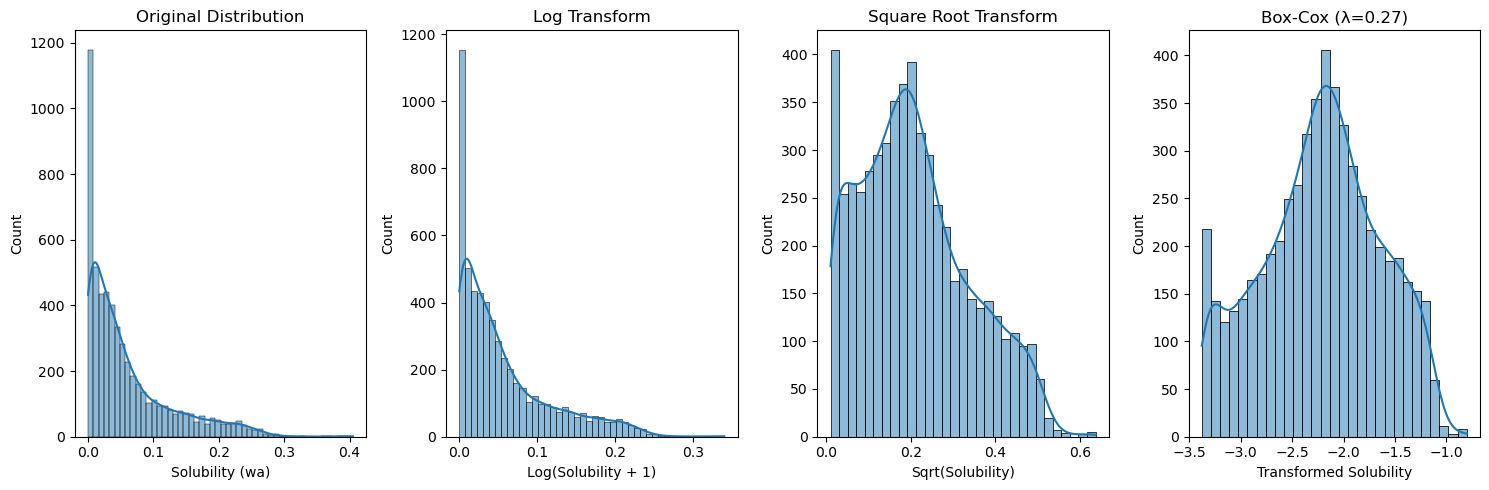

Box-Cox lambda: 0.2652


In [34]:
# Try different transformations
plt.figure(figsize=(15, 5))

# Original data
plt.subplot(1, 4, 1)
sns.histplot(df_co2_f['wa'], kde=True)
plt.title('Original Distribution')
plt.xlabel('Solubility (wa)')

# Log transform
plt.subplot(1, 4, 2)
sns.histplot(np.log1p(df_co2_f['wa']), kde=True)
plt.title('Log Transform')
plt.xlabel('Log(Solubility + 1)')

# Square root transform
plt.subplot(1, 4, 3)
sns.histplot(np.sqrt(df_co2_f['wa']), kde=True)
plt.title('Square Root Transform')
plt.xlabel('Sqrt(Solubility)')

# Box-Cox transform
from scipy import stats
transformed_data, lambda_value = stats.boxcox(df_co2_f['wa'] + 0.0001)  # Adding small constant to handle zeros
plt.subplot(1, 4, 4)
sns.histplot(transformed_data, kde=True)
plt.title(f'Box-Cox (λ={lambda_value:.2f})')
plt.xlabel('Transformed Solubility')

plt.tight_layout()
plt.show()
print(f"Box-Cox lambda: {lambda_value:.4f}")

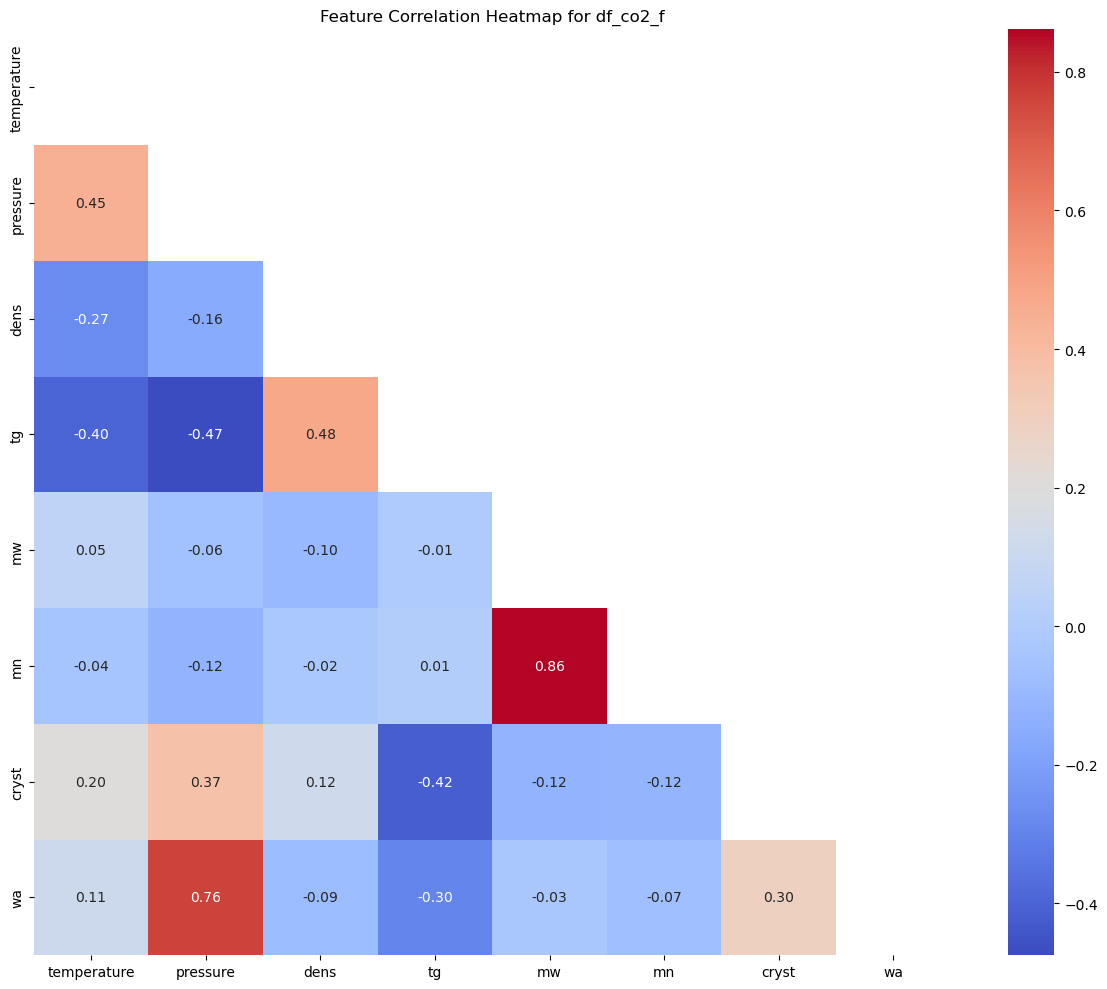

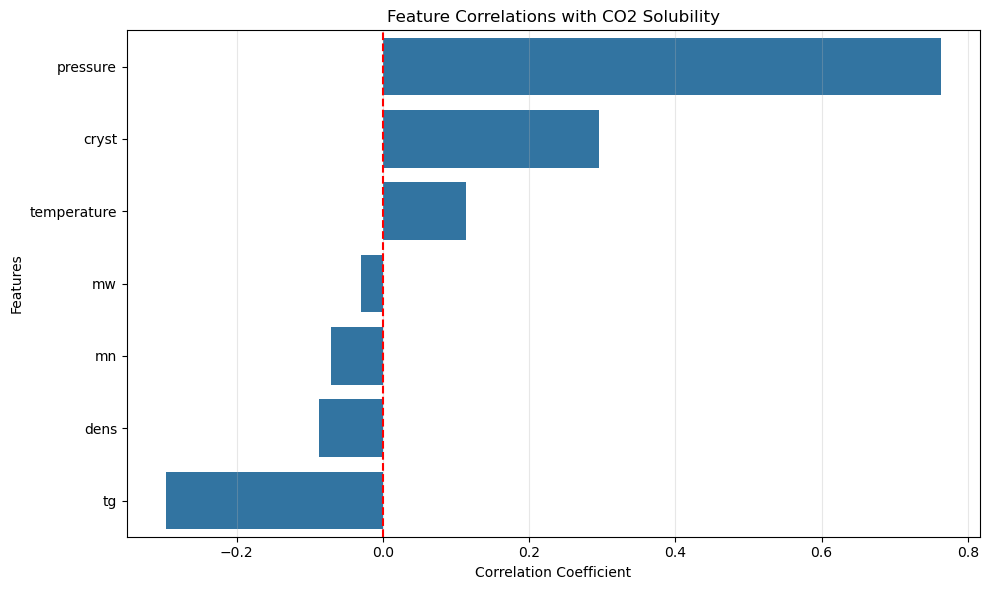

Features sorted by absolute correlation with CO2 solubility:
pressure       0.762928
tg             0.297122
cryst          0.295762
temperature    0.113422
dens           0.086800
mn             0.070553
mw             0.029453
Name: wa, dtype: float64

Feature pairs with strong correlations (above 0.7):
mn & mw: 0.861
wa & pressure: 0.763


In [35]:
# Correlation analysis for df_co2_f
plt.figure(figsize=(12, 10))
correlation = df_co2_f.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Create upper triangle mask
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Feature Correlation Heatmap for df_co2_f')
plt.tight_layout()
plt.show()

# Calculate and display correlation with target
target_corr = correlation[TARGET_COL].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values[1:], y=target_corr.index[1:])  # Exclude the target's correlation with itself
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Feature Correlations with CO2 Solubility')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print sorted correlations with target
print("Features sorted by absolute correlation with CO2 solubility:")
print(target_corr[1:].abs().sort_values(ascending=False))

# Identify multicollinearity between features
print("\nFeature pairs with strong correlations (above 0.7):")
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.7 and i != j:
            print(f"{correlation.columns[i]} & {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")

- Analysis: `Mw` is highly correlated to `Mn`.
- Action: remove `Mn`.

# Splitting, Preprocessing, Training, Evaluation

In [36]:
# Modified approach: Split data first, then apply preprocessing
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define our feature set (without 'cryst' and 'mn' based on previous analysis)
features = ["temperature", "pressure", "dens", "tg", "mw"]
TARGET_COL = 'wa'

# Step 2: Create a working copy of the dataset
df_work = df_co2[features + [TARGET_COL]].copy()
print(f"Initial dataset shape: {df_work.shape}")
print(f"NaN values: \n{df_work.isnull().sum()}")

# Step 3: Handle missing values
# df_work = df_work.dropna()
print(f"Dataset shape after dropping NaNs: {df_work.shape}")



Initial dataset shape: (5635, 6)
NaN values: 
temperature    0
pressure       0
dens           0
tg             0
mw             0
wa             0
dtype: int64
Dataset shape after dropping NaNs: (5635, 6)


In [37]:
# Step 4: Split the data BEFORE preprocessing
# This avoids data leakage from test to train
X = df_work[features].copy()
y = df_work[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Training set: 4508 samples
Test set: 1127 samples


Outliers in temperature (training data): 425 points
  Range: 448.15 to 508.15
Outliers in pressure (training data): 452 points
  Range: 18.28 to 44.5541235255298
Outliers in dens (training data): 24 points
  Range: 1.78 to 2.175
Outliers in tg (training data): 0 points
Outliers in mw (training data): 369 points
  Range: 451000.0 to 2200000.0
Transformation for temperature: λ=-3.9633, Original skew: 1.12
Transformation for pressure: λ=0.1707, Original skew: 1.27
Transformation for dens: λ=0.8918, Original skew: 0.04
After transformation temperature: Skew = 0.00
After transformation pressure: Skew = -0.15
After transformation dens: Skew = -0.01


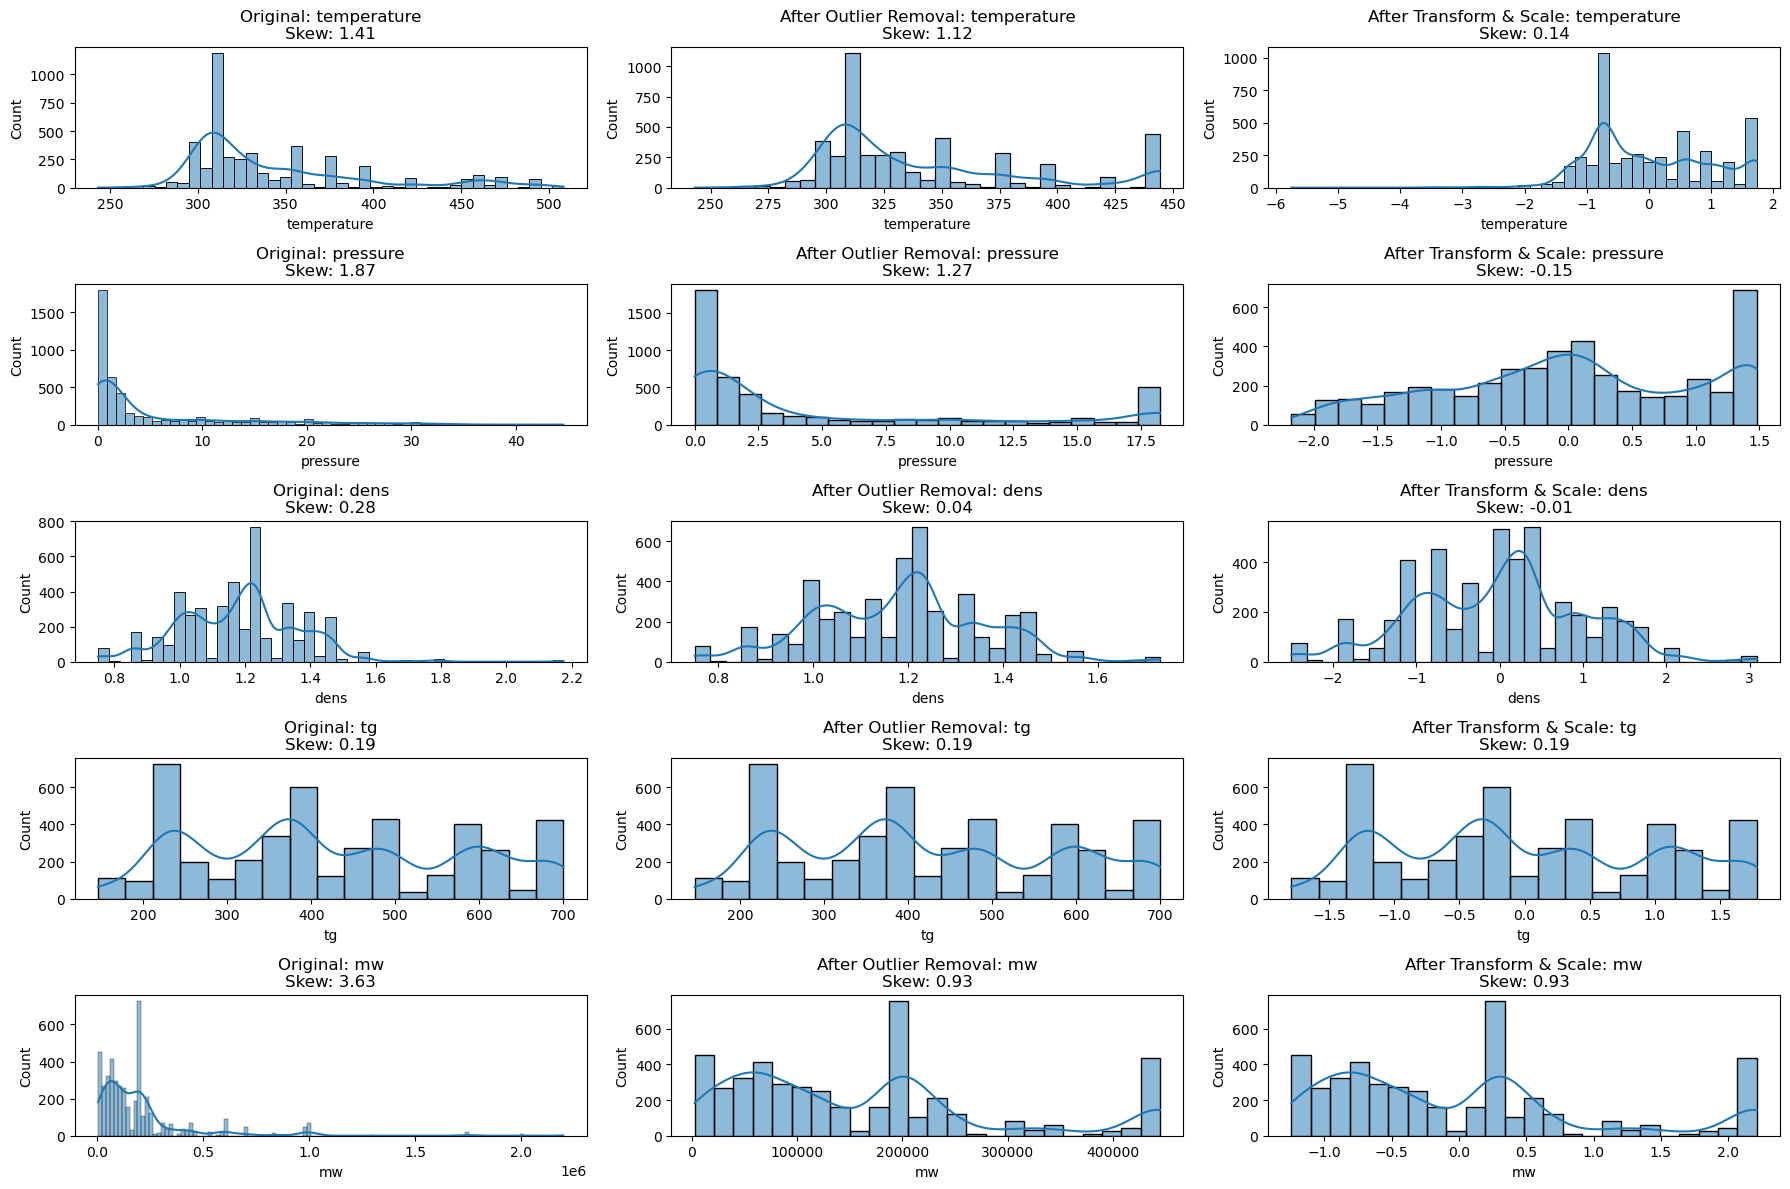

Data preprocessing complete!
Final training set: (4508, 5)
Final test set: (1127, 5)

First 5 indices of training data:
Original: Index([5476, 3835, 4099, 2539, 1548], dtype='int64')
After processing: Index([5476, 3835, 4099, 2539, 1548], dtype='int64')


In [38]:
# Step 5: Process the TRAINING data only
# 5.1: Identify outliers using the IQR method (ONLY on training data)
outliers_by_column = {}
iqr_bounds = {}  # Store bounds for later application to test set

for col in features:
    # Calculate IQR bounds from TRAINING data only
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Store bounds for this column (will apply to both train and test later)
    iqr_bounds[col] = (lower_bound, upper_bound)
    
    # Identify outliers in training set
    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)][col]
    outliers_by_column[col] = len(outliers)
    
    print(f"Outliers in {col} (training data): {len(outliers)} points")
    if len(outliers) > 0:
        print(f"  Range: {outliers.min()} to {outliers.max()}")

# 5.2: Handle outliers by clipping (apply to both train and test sets)
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

for col in features:
    lower_bound, upper_bound = iqr_bounds[col]
    
    # Clip the values in both training and test sets
    X_train_clean[col] = np.clip(X_train_clean[col], lower_bound, upper_bound)
    X_test_clean[col] = np.clip(X_test_clean[col], lower_bound, upper_bound)

# 5.3: Apply Box-Cox transformations based on previous analysis
# Only learn parameters from training data, but apply to both training and test
transform_features = ["temperature", "pressure", "dens"]
lambdas = {}  # Store lambda values for each feature
shifts = {}   # Store shifts for features with non-positive values

# First pass: determine lambdas and shifts from training data only
for col in transform_features:
    train_data = X_train_clean[col].values
    
    # Check if data contains zeros or negative values
    min_val = np.min(train_data)
    shift = 0
    if min_val <= 0:
        shift = abs(min_val) + 0.01
        train_data = train_data + shift
        shifts[col] = shift
        print(f"Applying shift of {shift} to {col}")
    
    try:
        # Apply Box-Cox transformation to training data to learn parameters
        transformed_data, lambda_val = stats.boxcox(train_data)
        lambdas[col] = lambda_val
        
        # Original skew for reference
        original_skew = X_train_clean[col].skew()
        print(f"Transformation for {col}: λ={lambda_val:.4f}, Original skew: {original_skew:.2f}")
    except Exception as e:
        print(f"Error transforming {col}: {str(e)}")
        # If transformation fails, remove from transform_features
        transform_features.remove(col)

# Second pass: apply transformations to both train and test using parameters from training
X_train_transformed = X_train_clean.copy()
X_test_transformed = X_test_clean.copy()

for col in transform_features:
    # Get lambda and shift (if any)
    lambda_val = lambdas[col]
    shift = shifts.get(col, 0)
    
    # Apply shift if needed
    if shift > 0:
        X_train_transformed[col] = X_train_transformed[col] + shift
        X_test_transformed[col] = X_test_transformed[col] + shift
    
    # Apply Box-Cox transformation
    if lambda_val == 0:
        # log transform for lambda = 0
        X_train_transformed[col] = np.log(X_train_transformed[col])
        X_test_transformed[col] = np.log(X_test_transformed[col])
    else:
        X_train_transformed[col] = (X_train_transformed[col] ** lambda_val - 1) / lambda_val
        X_test_transformed[col] = (X_test_transformed[col] ** lambda_val - 1) / lambda_val
    
    # Print skew after transformation (training data only)
    new_skew = X_train_transformed[col].skew()
    print(f"After transformation {col}: Skew = {new_skew:.2f}")

# 5.4: Scale the features using StandardScaler (fit on training, apply to both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test_transformed)        # Apply same scaling to test data

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Step 6: Visualize the effect of preprocessing on training data
plt.figure(figsize=(18, 12))

for i, col in enumerate(features):
    # Original distribution
    plt.subplot(len(features), 3, i*3 + 1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Original: {col}\nSkew: {X_train[col].skew():.2f}')
    
    # After outlier removal
    plt.subplot(len(features), 3, i*3 + 2)
    sns.histplot(X_train_clean[col], kde=True)
    plt.title(f'After Outlier Removal: {col}\nSkew: {X_train_clean[col].skew():.2f}')
    
    # After transformation and scaling
    plt.subplot(len(features), 3, i*3 + 3)
    sns.histplot(X_train_scaled_df[col], kde=True)
    plt.title(f'After Transform & Scale: {col}\nSkew: {X_train_scaled_df[col].skew():.2f}')

plt.tight_layout()
plt.show()

# Step 7: Final processed datasets ready for modeling
print("Data preprocessing complete!")
print(f"Final training set: {X_train_scaled_df.shape}")
print(f"Final test set: {X_test_scaled_df.shape}")

# Confirm identities are preserved after all transformations
print("\nFirst 5 indices of training data:")
print(f"Original: {X_train.index[:5]}")
print(f"After processing: {X_train_scaled_df.index[:5]}")

In [39]:
# Step 11: Model Training with Cross-Validation
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import joblib

# Initialize cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_SEED),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM_SEED),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_SEED),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_SEED),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Initialize results dictionaries
cv_rmse = {}
cv_mae = {}
cv_r2 = {}
training_time = {}

print("\nStarting model training and cross-validation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Record start time
    start_time = time.time()
    
    # Perform cross-validation
    rmse_scores = -cross_val_score(model, X_train_scaled_df, y_train, scoring='neg_root_mean_squared_error', cv=cv)
    mae_scores = -cross_val_score(model, X_train_scaled_df, y_train, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(model, X_train_scaled_df, y_train, scoring='r2', cv=cv)
    
    # Record end time and calculate duration
    end_time = time.time()
    training_duration = end_time - start_time
    
    # Save mean scores
    cv_rmse[name] = rmse_scores.mean()
    cv_mae[name] = mae_scores.mean()
    cv_r2[name] = r2_scores.mean()
    training_time[name] = training_duration
    
    print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"  R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print(f"  Training time: {training_duration:.2f} seconds\n")




Starting model training and cross-validation...

Training Linear Regression...
  RMSE: 0.0416 ± 0.0011
  MAE: 0.0321 ± 0.0007
  R²: 0.6051 ± 0.0107
  Training time: 0.06 seconds

Training Ridge...
  RMSE: 0.0416 ± 0.0011
  MAE: 0.0321 ± 0.0007
  R²: 0.6051 ± 0.0107
  Training time: 0.03 seconds

Training Lasso...
  RMSE: 0.0663 ± 0.0020
  MAE: 0.0509 ± 0.0014
  R²: -0.0028 ± 0.0023
  Training time: 0.03 seconds

Training ElasticNet...
  RMSE: 0.0663 ± 0.0020
  MAE: 0.0509 ± 0.0014
  R²: -0.0028 ± 0.0023
  Training time: 0.03 seconds

Training K-Nearest Neighbors...
  RMSE: 0.0159 ± 0.0012
  MAE: 0.0084 ± 0.0007
  R²: 0.9424 ± 0.0061
  Training time: 0.09 seconds

Training Decision Tree...
  RMSE: 0.0298 ± 0.0010
  MAE: 0.0190 ± 0.0009
  R²: 0.7960 ± 0.0219
  Training time: 0.08 seconds

Training Random Forest...
  RMSE: 0.0136 ± 0.0006
  MAE: 0.0068 ± 0.0003
  R²: 0.9575 ± 0.0018
  Training time: 10.76 seconds

Training Gradient Boosting...
  RMSE: 0.0173 ± 0.0005
  MAE: 0.0112 ± 0.00

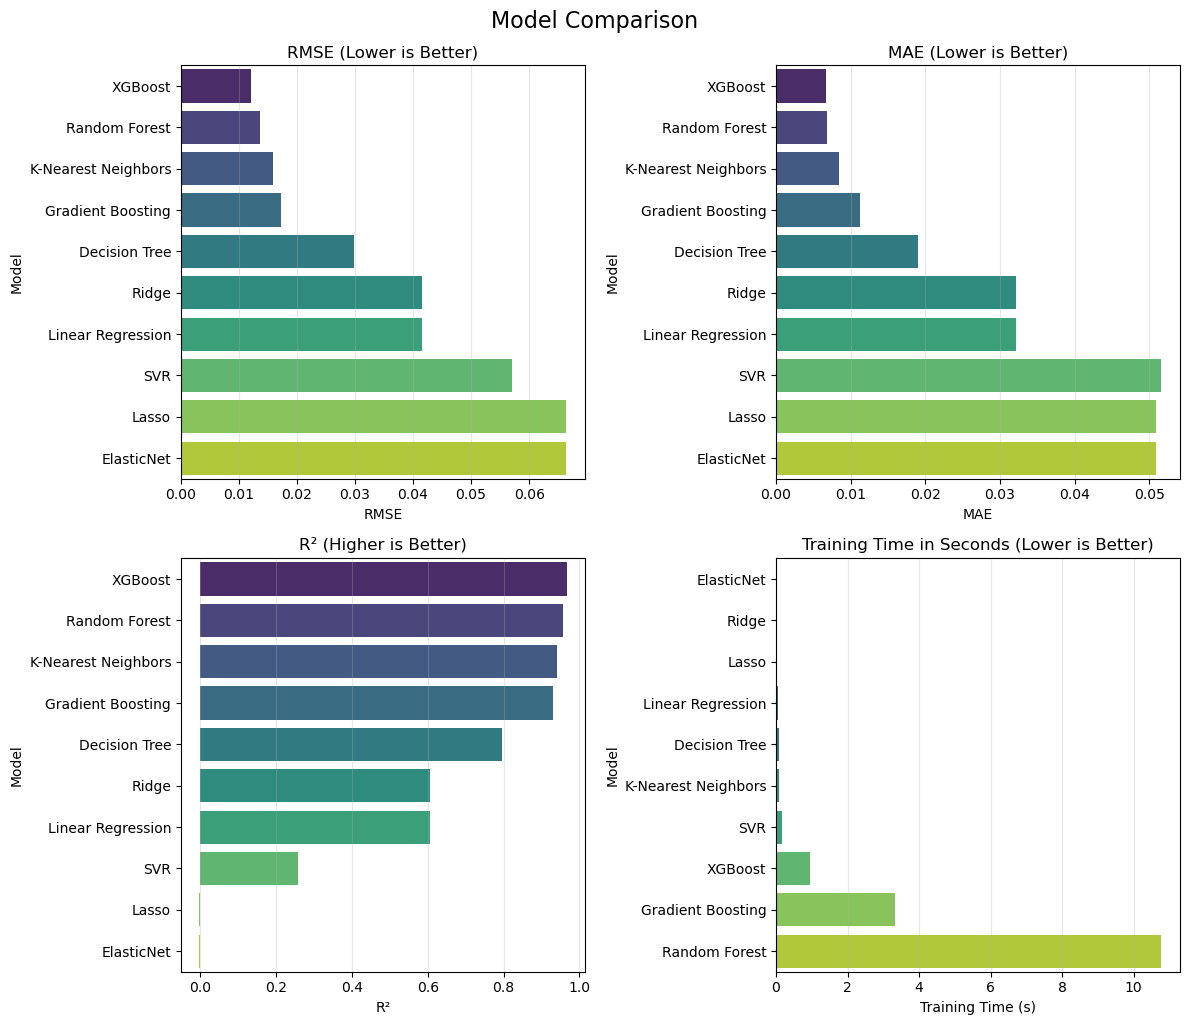

In [40]:
# Step 12: Visualize model comparison
plt.figure(figsize=(12, 10))

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'RMSE': list(cv_rmse.values()),
    'MAE': list(cv_mae.values()),
    'R²': list(cv_r2.values()),
    'Training Time (s)': list(training_time.values())
})

# Sort by RMSE (lower is better)
results_df = results_df.sort_values('RMSE')

# Plot RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('RMSE (Lower is Better)')
plt.grid(axis='x', alpha=0.3)

# Plot MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')
plt.title('MAE (Lower is Better)')
plt.grid(axis='x', alpha=0.3)

# Plot R² comparison
plt.subplot(2, 2, 3)
sns.barplot(x='R²', y='Model', data=results_df.sort_values('R²', ascending=False), palette='viridis')
plt.title('R² (Higher is Better)')
plt.grid(axis='x', alpha=0.3)

# Plot training time comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Training Time (s)', y='Model', data=results_df.sort_values('Training Time (s)'), palette='viridis')
plt.title('Training Time in Seconds (Lower is Better)')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Model Comparison', y=1.02, fontsize=16)
plt.show()



In [41]:
# Step 13: Select the best model for hyperparameter tuning
# Identify best performing model based on RMSE
best_model_name = min(cv_rmse, key=cv_rmse.get)
print(f"Best performing model: {best_model_name} with RMSE = {cv_rmse[best_model_name]:.4f}")



Best performing model: XGBoost with RMSE = 0.0122


In [42]:
# Step 14: Hyperparameter tuning for the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Define hyperparameter grid based on the best model type
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    base_model = XGBRegressor(random_state=RANDOM_SEED)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestRegressor(random_state=RANDOM_SEED)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingRegressor(random_state=RANDOM_SEED)
    
elif best_model_name == 'SVR':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    base_model = SVR()
    
else:  # Default simple grid for other models
    param_grid = {
        'fit_intercept': [True, False]
    }
    base_model = models[best_model_name]

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled_df, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")




Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE: 0.0108


In [43]:
# Step 15: Evaluate the best model on test data
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled_df, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test_scaled_df)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nTest set evaluation:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")




Test set evaluation:
RMSE: 0.0097
MAE: 0.0050
R²: 0.9762


findfont: Font family 'ReithSans' not found.


findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: 

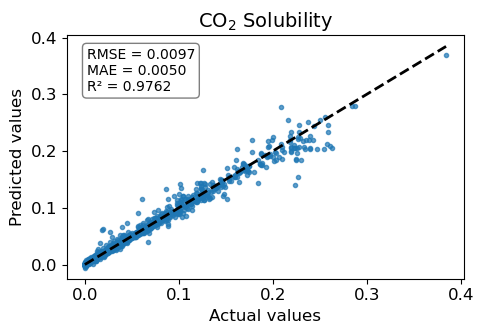

In [53]:
# Step 16: Visualize predictions vs actual values

# Plots for BBC Interview
plt.rcParams['font.family'] = ['ReithSans', 'sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'normal'
plt.figure(figsize=(5, 3.5))

# plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(r'CO$_2$ Solubility')
# plt.grid(True, alpha=0.3)

# Add the error metrics to the plot
textstr = f'RMSE = {test_rmse:.4f}\nMAE = {test_mae:.4f}\nR² = {test_r2:.4f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction', bbox=props,
             verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.savefig('predict_actual.png', dpi=500)
plt.show()



findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: Font family 'ReithSans' not found.
findfont: 

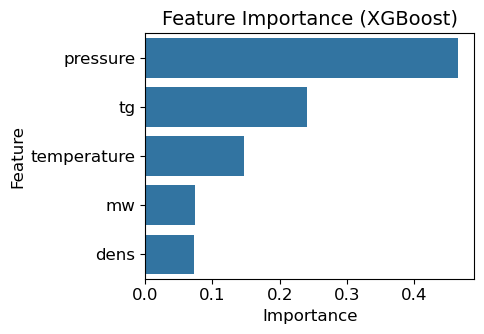


Feature Importance:
  pressure: 0.4659
  tg: 0.2410
  temperature: 0.1475
  mw: 0.0733
  dens: 0.0724


In [58]:
# Step 17: Feature importance for the best model (if available)

try:
    # Extract feature importances if the model supports it
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)
        
        # plt.figure(figsize=(10, 6))
        # Plots for BBC Interview
        plt.rcParams['font.family'] = ['ReithSans', 'sans-serif']
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['axes.titleweight'] = 'normal'
        plt.figure(figsize=(5, 3.5))

        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance ({best_model_name})')
        # plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=500)
        plt.show()
        
        print("\nFeature Importance:")
        for idx, row in importance_df.iterrows():
            print(f"  {row['Feature']}: {row['Importance']:.4f}")
            
    elif best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
        # For linear models, use coefficients
        coefficients = best_model.coef_
        importance_df = pd.DataFrame({
            'Feature': features,
            'Coefficient': coefficients
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Coefficient', y='Feature', data=importance_df)
        plt.title(f'Feature Coefficients ({best_model_name})')
        # plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nFeature Coefficients:")
        for idx, row in importance_df.iterrows():
            print(f"  {row['Feature']}: {row['Coefficient']:.4f}")
            
except Exception as e:
    print(f"\nCouldn't extract feature importance: {str(e)}")



In [ ]:
# Step 18: Save the best model
model_filename = f"../models/best_co2_solubility_model_{best_model_name.replace(' ', '_').lower()}.pkl"
try:
    # Ensure directory exists
    os.makedirs(os.path.dirname(model_filename), exist_ok=True)
    joblib.dump(best_model, model_filename)
    print(f"\nBest model saved to {model_filename}")
except Exception as e:
    print(f"Error saving model: {str(e)}")
    # Fallback to current directory
    model_filename = f"best_co2_solubility_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Best model saved to current directory as {model_filename}")


Best model saved to ../models/best_co2_solubility_model_xgboost.pkl
